# Complex Networks Analysis Project: A Study of the Air Transportation Multiplex Dataset

This notebook is devoted to presenting all the code and reasonings of our project for the Complex Networks Analysis course of the Master in Fundamental Principles of Data Science.

Here, we analyze the "Air Transportation Multiplex" dataset, which contains a multiplex network of airline routes among European airports, where each of the 37 edge types represents routes by a different airline. It is an undirected, multiplex and unweighted network.

For **Task 1**, we have done the following work:

- **Data Reading and Network Visualization**.
- **Selection of Networks for Analysis**.
- **Microscale Analysis**.
- **Macroscale Analysis**.

For **Task 2**, the following analyses were performed:
- **...**

***

### Necessary Imports and Directory Management


In [1]:
# Reset the kernel
%reset -f

# Necessary imports
import folium
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import pickle
import networkx as nx
from networkx import community as nx_comm

from tqdm.auto import tqdm
import pandas as pd
import ipywidgets as widgets
from IPython.display import display, clear_output

from PIL import Image
import io

from pathlib import Path


In [2]:
# Directories
DATA_DIR = Path("../Data")
OUTPUT_DIR = Path("../Output")


***

## **TASK 1**



### **1. Data Reading and Network Visualization**

#### 1.1. Data Reading

In [3]:
# Read the file containing the airport information
df_airports = pd.read_csv(
    DATA_DIR / "airports.tsv",
    sep="\t",
    header=None,
    names=["node_id", "icao_code", "longitude", "latitude"],
)

# Read the file containing airport names
df_airport_names = pd.read_csv(
    DATA_DIR / "icao-to-airport-name.csv",
    sep=",",
    index_col=0,
)

# Join the two dataframes
df_airports = df_airports.join(
    df_airport_names, on="icao_code", how="left"
)


In [4]:
# Read the file containing the airport connections
def read_multilayer_connections(
    file_path: Path,
) -> list[dict]:
    """Reads the multilayer connections from a file.

    Args:
        file_path (Path) -- Path to the file containing the multilayer connections.

    Returns:
        list -- List containing the multilayer connections.
    """
    layers = []

    with Path.open(file_path, "r") as f_in:
        lines = [line.strip() for line in f_in if line.strip()]

    i = 0
    while i < len(lines):
        num_nodes = int(lines[i])
        i += 1

        edges = set()
        for _ in range(num_nodes):
            parts = lines[i].split()
            node_id = int(parts[0])
            neighbors = list(map(int, parts[2:]))
            for neighbor in neighbors:
                edge = tuple(sorted((node_id, neighbor)))  # Undirected
                edges.add(edge)
            i += 1

        layers.append({
            "active_nodes": num_nodes,
            "edges": edges
        })

    return layers


In [5]:
# Read the layers
layers = read_multilayer_connections(DATA_DIR / "network.txt")


In [6]:
# Convert each layer to a NetworkX graph
def create_graph_from_layer(layer: dict) -> nx.Graph:
    """Creates a NetworkX graph from a layer.

    Args:
        layer (dict) -- Layer containing the active nodes and edges.

    Returns:
        nx.Graph -- NetworkX graph.
    """
    G = nx.Graph()
    G.add_edges_from(layer["edges"])
    return G

# Create a list of NetworkX graphs for each layer
graphs = [create_graph_from_layer(layer) for layer in layers]


In [7]:
# Construct the newtork resulting from collapsing the multilayer network
def collapse_multilayer_network(layers: list[dict]) -> nx.Graph:
    """Collapses the multilayer network into a single layer.

    Args:
        layers (list) -- List containing the multilayer connections.

    Returns:
        nx.Graph -- Collapsed multilayer network.
    """
    G = nx.Graph()

    for layer in layers:
        edges = layer["edges"]
        G.add_edges_from(edges)

    return G

# Collapse the multilayer network
ntw_all = collapse_multilayer_network(layers)
graphs.append(ntw_all)


#### 1.2. Network Visualization

We have developed an interactive visualization of the network, consisting of a map with a selector that allows to visualize the transportation network for each of the 37 airlines.

<div class="alert alert-block alert-danger">
<b>IMPORTANT:</b> In order for the visualization to be displayed, the corresponding notebook cells need to be rerun each time the notebook is opened. Please run all the cells to dynamically visualize the networks.
</div>

In [8]:
# Function to plot the graph as an interactive map
def plot_interactive_map(G: nx.Graph, df_airports: pd.DataFrame, node_colors: list[str] = None, edge_colors: list[str] = None) -> folium.Map:
    """Visualizes the network on a folium map.

    Args:
        G (nx.Graph) -- NetworkX graph object.
        df_airports (pd.DataFrame) -- DataFrame containing airport information.

    Returns:
        folium.Map -- Folium map with the network visualized.
    """
    # Create a folium map centered around the average coordinates
    m = folium.Map(location=[df_airports["latitude"].mean(), df_airports["longitude"].mean()], zoom_start=4)

    # Add edges to the map
    if edge_colors is None:
        for edge in G.edges():
            airport1 = df_airports[df_airports["node_id"] == edge[0]].iloc[0]
            airport2 = df_airports[df_airports["node_id"] == edge[1]].iloc[0]
            folium.PolyLine(
                locations=[[airport1["latitude"], airport1["longitude"]],
                        [airport2["latitude"], airport2["longitude"]]],
                color="blue",
                weight=2,
                opacity=0.6,
            ).add_to(m)
    else:
        for edge, color in zip(G.edges(), edge_colors):
            airport1 = df_airports[df_airports["node_id"] == edge[0]].iloc[0]
            airport2 = df_airports[df_airports["node_id"] == edge[1]].iloc[0]
            folium.PolyLine(
                locations=[[airport1["latitude"], airport1["longitude"]],
                        [airport2["latitude"], airport2["longitude"]]],
                color=color,
                weight=2,
                opacity=0.6,
            ).add_to(m)

    if node_colors is None:
        # Add nodes to the map
        for node in G.nodes():
            airport = df_airports[df_airports["node_id"] == node].iloc[0]
            folium.CircleMarker(
                location=[airport["latitude"], airport["longitude"]],
                radius=3,
                color="red",
                fill=True,
                fill_color="red",
                popup=airport["name"],
            ).add_to(m)
    else:
        # Add nodes to the map with colors
        for node, color in zip(G.nodes(), node_colors):
            airport = df_airports[df_airports["node_id"] == node].iloc[0]
            folium.CircleMarker(
                location=[airport["latitude"], airport["longitude"]],
                radius=3,
                color=color,
                fill=True,
                fill_color=color,
                popup=airport["name"],
            ).add_to(m)

    return m


In [9]:
# Load airline names from TSV
df_airlines = pd.read_csv(DATA_DIR / "airlines.tsv", sep="\t")
airline_names = df_airlines.sort_values("Id")["Airline"].tolist()

# Create dropdown with airline names
airline_dropdown = widgets.Dropdown(
    options=[(name, idx) for idx, name in enumerate(airline_names)],
    description='Airline:',
    style={'description_width': 'initial'}
)

# Output widget to hold the map
map_output = widgets.Output()

# Define update function
def update_map(change):
    with map_output:
        clear_output(wait=True)
        layer_index = change['new']
        m = plot_interactive_map(
            graphs[layer_index],
            df_airports,
        )
        display(m)

# Connect dropdown to update function
airline_dropdown.observe(update_map, names='value')

# Display the widgets
display(airline_dropdown, map_output)

# Trigger initial map update manually
update_map({'new': airline_dropdown.value})


Dropdown(description='Airline:', options=(('Lufthansa', 0), ('Ryanair', 1), ('Easyjet', 2), ('British Airways'…

Output()

By visually inspecting each airline’s network, we can identify distinct "families" based on their structural patterns:

- **Traditional airlines**, such as Lufthansa, Air France or SWISS, rely on a **hub and spoke** model. In this structure, a few central airports handle the majority of the traffic, serving as hubs through which most connections are routed.
- **Non-traditional, low-cost airlines**, such as Ryanair or WizzAir, tend to rely on a **point-to-point** model. This approach avoids centralized hubs, instead connecting airports more evenly and directly, with no single airport dominating the network.

### **2. Selection of Networks for Analysis**

Since the downloaded network includes data from 37 different airlines, we decided to perform data selection and focus our analysis on a subset of airline networks. This restriction allows for clearer visualizations and a more interpretable analysis of each airline’s network structure.

We have chosen to analyze the following airlines:

- **Lufthansa**: traditional hub-and-spoke airline. By visual inspection, we can see that presents not a single but few central nodes in major German airports.
- **Air France**: traditional hub-and-spoke airline. By visual inspection, we can see that presents a single central hub in Paris.
- **Ryanair**: non-traditional, low-cost airline. By visual inspection, we can see that its network is very dense and does not present any apparent central node.

Moreover, we construct and study the **network resulting from collapsing all airline networks toghether**, which we think is a good representation of general aviation traffic in Europe.

Our main goal here is to see whether centrality measures can quantitatively prove the qualitative, visual observations we have done on the network representations.


In [10]:
# Function to select the network corresponding to the chosen airline
def select_airline_network(
    airline_name: str,
    airline_df: pd.DataFrame,
    graphs: list[nx.Graph],
) -> nx.Graph:
    """Selects the network corresponding to the chosen airline.

    Args:
        airline_name (str) -- Name of the airline.
        airline_df (pd.DataFrame) -- DataFrame containing airline information.
        graphs (list[nx.Graph]) -- List of networks.

    Returns:
        nx.Graph -- Object containing the selected network.
    """
    airline_id = airline_df[airline_df["Airline"] == airline_name]["Id"].values[0]
    graph_index = airline_id - 1
    return graphs[graph_index]


ntw_lufthansa = select_airline_network(
    airline_name="Lufthansa",
    airline_df=df_airlines,
    graphs=graphs,
)

ntw_air_france = select_airline_network(
    airline_name="Air France",
    airline_df=df_airlines,
    graphs=graphs,
)

ntw_ryanair = select_airline_network(
    airline_name="Ryanair",
    airline_df=df_airlines,
    graphs=graphs,
)

ntw_all = select_airline_network(
    airline_name="All",
    airline_df=df_airlines,
    graphs=graphs,
)


In [11]:
# Function to convert a folium dynamic map to a static image
def save_folium_map_as_image(m: folium.Map, out_path: Path) -> None:
    """Save the folium map as a PNG image.

    Arguments:
        m: folium.Map -- map object
        out_path: Path -- path to save the image
    """
    m.fit_bounds([[35, -10], [70, 30]])
    png_data = m._to_png(5)
    image = Image.open(io.BytesIO(png_data))

    image.save(out_path, "PNG")


In [12]:
FOLIUM_SAVE = False


In [13]:
if FOLIUM_SAVE:
    # Save the interactive maps as static images
    save_folium_map_as_image(
        m=plot_interactive_map(
            ntw_lufthansa,
            df_airports,
        ),
        out_path=OUTPUT_DIR / "ntw_lufthansa.png",
    )

    save_folium_map_as_image(
        m=plot_interactive_map(
            ntw_air_france,
            df_airports,
        ),
        out_path=OUTPUT_DIR / "ntw_air_france.png",
    )

    save_folium_map_as_image(
        m=plot_interactive_map(
            ntw_ryanair,
            df_airports,
        ),
        out_path=OUTPUT_DIR / "ntw_ryanair.png",
    )

    save_folium_map_as_image(
        m=plot_interactive_map(
            ntw_all,
            df_airports,
        ),
        out_path=OUTPUT_DIR / "ntw_all.png",
    )


In [14]:
# Function to plot static newtwork graphs
def plot_static_graph(
    network: nx.Graph,
    png_file_name: str,
    column: int,
    network_name: str,
    axs: list[plt.Axes],
    node_colors: list[str] = None
) -> None:
    """Plots a static network graph.

    Args:
        newtork: nx.Graph -- NetworkX graph object.
        png_file_name: str -- Name of the PNG file with the map plot.
        column: int -- Column index for the plot.
        network_name: str -- Name of the network.
    """
    axs[0, column].set_title(network_name, fontsize=20)
    axs[0, column].imshow(
        Image.open(OUTPUT_DIR / png_file_name).crop((513, 151, 833, 588)),
    )

    if node_colors is None:
        nx.draw(
            network,
            pos=nx.spring_layout(network),
            node_size=20,
            node_color="red",
            edge_color="blue",
            width=0.5,
            ax=axs[1, column],
        )
    else:
        nx.draw(
            network,
            pos=nx.spring_layout(network),
            node_size=20,
            node_color=node_colors,
            edge_color="blue",
            width=0.5,
            ax=axs[1, column],
        )



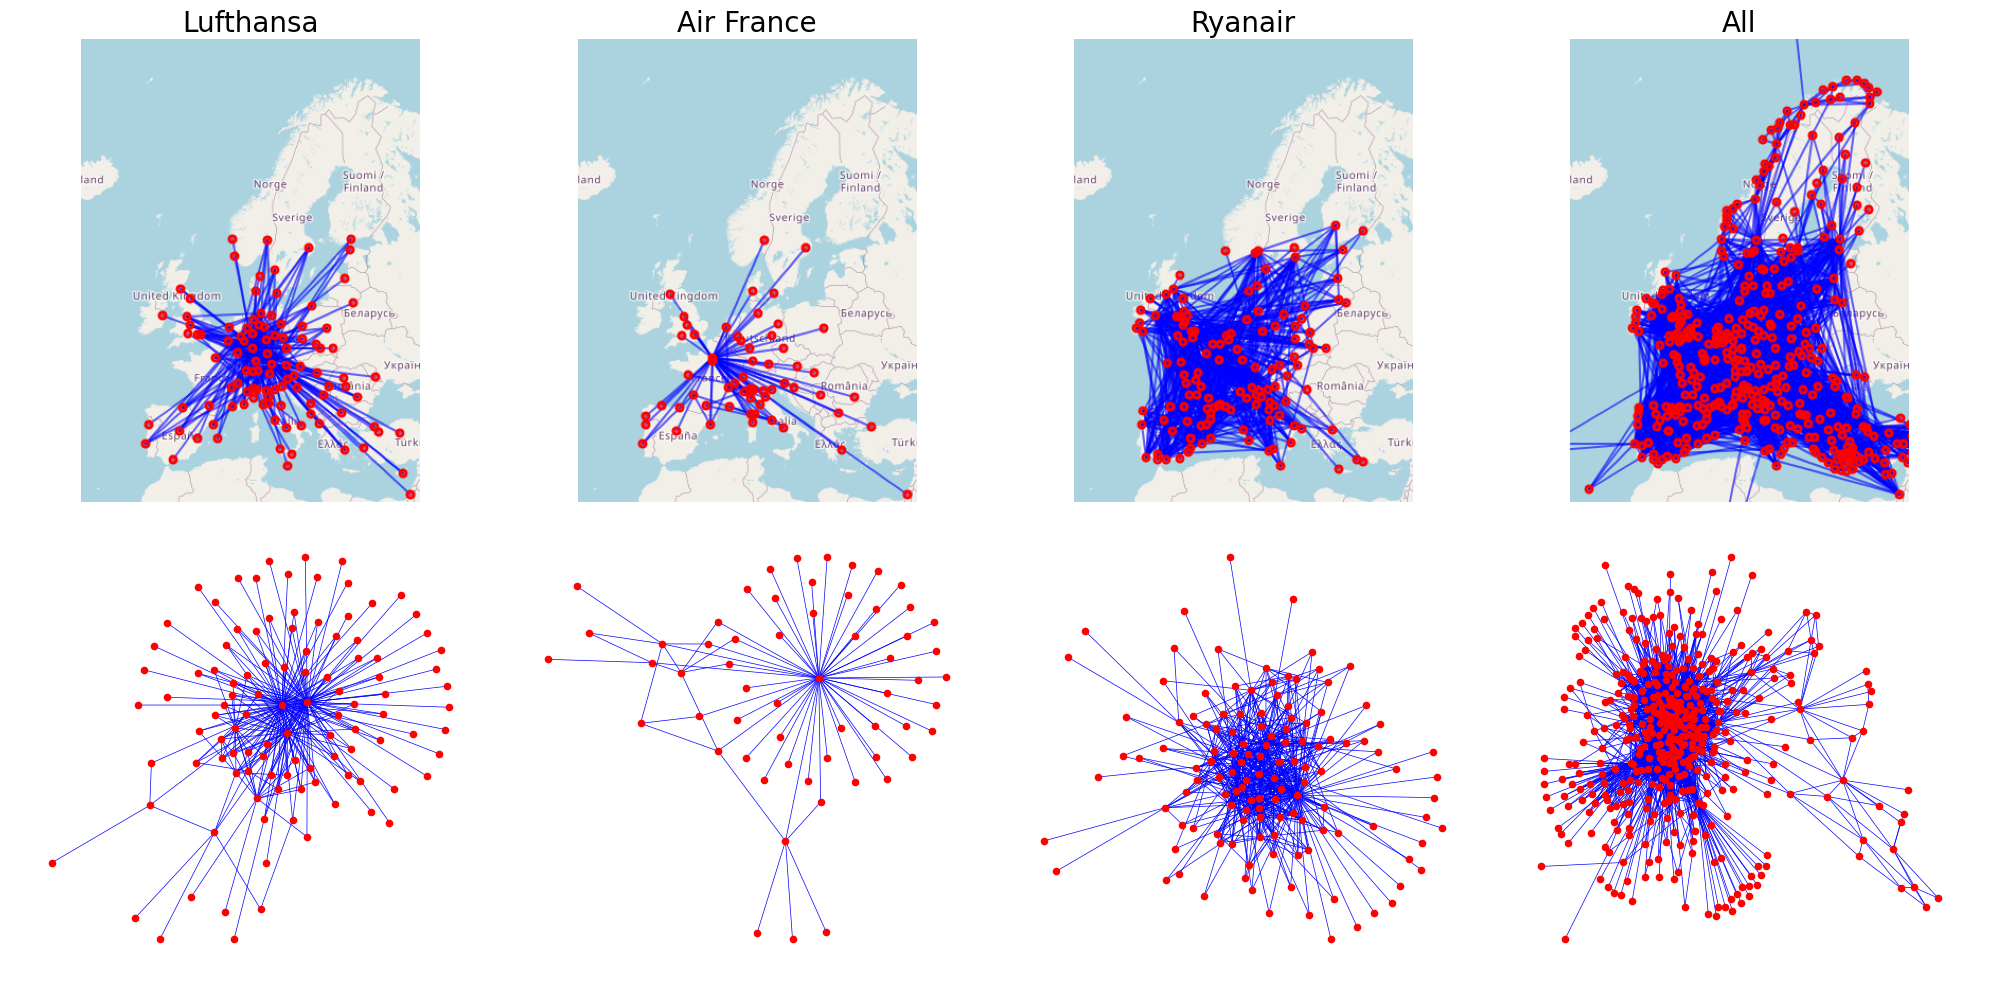

In [15]:
# Static plot of the newtorks to be studied
fig, axs = plt.subplots(2, 4, figsize=(20, 10))

for ax in axs.flatten():
    ax.set_axis_off()

plot_static_graph(
    network=ntw_lufthansa,
    png_file_name="ntw_lufthansa.png",
    column=0,
    network_name="Lufthansa",
    axs=axs,
)

plot_static_graph(
    network=ntw_air_france,
    png_file_name="ntw_air_france.png",
    column=1,
    network_name="Air France",
    axs=axs,
)

plot_static_graph(
    network=ntw_ryanair,
    png_file_name="ntw_ryanair.png",
    column=2,
    network_name="Ryanair",
    axs=axs,
)

plot_static_graph(
    network=ntw_all,
    png_file_name="ntw_all.png",
    column=3,
    network_name="All",
    axs=axs,
)

plt.tight_layout()
plt.show()


### **3. Microscale Analysis**

We will compute the following microscale measures for each airport (node) and each airline network:
- Degree centrality.
- Closeness centrality.
- Betweenness centrality.
- Eigenvector centrality.
- Page-rank centrality.
- Katz centrality.
- Clustering coefficient.

Data will be organized in the following structure:
```
f{airline_name}_microscale_data = [
    {
        f{airport_id}: {
            "degree_centrality": float,
            "closeness_centrality": float,
            ...
        },
        ...
    }
    ...
]
```

In [16]:
# List of airports ids

airports_ids = df_airports["node_id"].tolist()

# List of microscale measures
microscale_measures = [
    "degree_centrality",
    "closeness_centrality",
    "betweenness_centrality",
    "eigenvector_centrality",
    "pagerank_centrality",
    "katz_centrality",
    "clustering_coefficient",
]


def generate_microscale_data_structure(
    airports_ids: list[int],
    microscale_measures: list[str],
) -> list[dict]:
    """Generates a data structure for microscale measures.

    Args:
        airports_ids (list[int]) -- List of airport IDs.
        microscale_measures (list[str]) -- List of microscale measures.

    Returns:
        list[dict] -- Data structure for microscale measures.
    """
    return {
            airport_id: {
                centrality_measure: np.nan
                for centrality_measure in microscale_measures
            }
        for airport_id in airports_ids
        }

# Create a data structure for each airline
lufthansa_microscale_data = generate_microscale_data_structure(
    airports_ids=ntw_lufthansa.nodes(),
    microscale_measures=microscale_measures,
)
air_france_microscale_data = generate_microscale_data_structure(
    airports_ids=ntw_air_france.nodes(),
    microscale_measures=microscale_measures,
)
ryanair_microscale_data = generate_microscale_data_structure(
    airports_ids=ntw_ryanair.nodes(),
    microscale_measures=microscale_measures,
)
all_microscale_data = generate_microscale_data_structure(
    airports_ids=ntw_all.nodes(),
    microscale_measures=microscale_measures,
)


In [17]:
# Fill the data structure with the microscale measures
def fill_microscale_data_structure(
    microscale_data: list[dict],
    network: nx.Graph,
) -> None:
    """Fills the microscale data structure with measures.

    Args:
        microscale_data (list[dict]) -- Data structure for microscale measures.
        network (nx.Graph) -- NetworkX graph object.
    """

    for node in tqdm(network.nodes()):
        for measure in microscale_measures:
            match measure:
                case "degree_centrality":
                    microscale_data[node][measure] = nx.degree_centrality(network)[node]
                case "closeness_centrality":
                    microscale_data[node][measure] = nx.closeness_centrality(network)[node]
                case "betweenness_centrality":
                    microscale_data[node][measure] = nx.betweenness_centrality(network)[node]
                case "eigenvector_centrality":
                    microscale_data[node][measure] = nx.eigenvector_centrality(network)[node]
                case "pagerank_centrality":
                    microscale_data[node][measure] = nx.pagerank(network)[node]
                case "katz_centrality":
                    microscale_data[node][measure] = nx.katz_centrality_numpy(network)[node]
                    pass
                case "clustering_coefficient":
                    microscale_data[node][measure] = nx.clustering(network, node)
                case _:
                    raise ValueError(f"Unknown measure: {measure}")

    return microscale_data

# Save the microscale data to pickle files
def save_microscale_data(
    microscale_data: list[dict],
    airline_name: str,
) -> None:
    """Saves the microscale data to a pickle file.

    Args:
        microscale_data (list[dict]) -- Microscale data structure.
        airline_name (str) -- Name of the airline.
    """
    with open(OUTPUT_DIR / f"{airline_name}_microscale_data.pkl", "wb") as f:
        pickle.dump(microscale_data, f)

# Load the microscale data from pickle files
def load_microscale_data(
    airline_name: str,
) -> list[dict]:
    """Loads the microscale data from a pickle file.

    Args:
        airline_name (str) -- Name of the airline.

    Returns:
        list[dict] -- Microscale data structure.
    """
    with open(OUTPUT_DIR / f"{airline_name}_microscale_data.pkl", "rb") as f:
        microscale_data = pickle.load(f)
    return microscale_data


In [18]:
COMPUTE_MIRCOSCALE_DATA = False


In [19]:
# Fill the microscale data structure for each airline
if COMPUTE_MIRCOSCALE_DATA:
    lufthansa_microscale_data = fill_microscale_data_structure(
        microscale_data=lufthansa_microscale_data,
        network=ntw_lufthansa,
    )
    save_microscale_data(
        microscale_data=lufthansa_microscale_data,
        airline_name="lufthansa",
    )

    air_france_microscale_data = fill_microscale_data_structure(
        microscale_data=air_france_microscale_data,
        network=ntw_air_france,
    )
    save_microscale_data(
        microscale_data=air_france_microscale_data,
        airline_name="air_france",
    )

    ryanair_microscale_data = fill_microscale_data_structure(
        microscale_data=ryanair_microscale_data,
        network=ntw_ryanair,
    )
    save_microscale_data(
        microscale_data=ryanair_microscale_data,
        airline_name="ryanair",
    )

    all_microscale_data = fill_microscale_data_structure(
        microscale_data=all_microscale_data,
        network=ntw_all,
    )
    save_microscale_data(
        microscale_data=all_microscale_data,
        airline_name="all",
    )

else:
    lufthansa_microscale_data = load_microscale_data(
        airline_name="lufthansa",
    )
    air_france_microscale_data = load_microscale_data(
        airline_name="air_france",
    )
    ryanair_microscale_data = load_microscale_data(
        airline_name="ryanair",
    )
    all_microscale_data = load_microscale_data(
        airline_name="all",
    )




**Calculate the TOP-K central airports of each airline**

In [20]:
def top_k_central_nodes(
    microscale_data: dict,
    k: int,
    measure_name: str,
    *,
    df_airports: pd.DataFrame | None = None,
) -> list[tuple[int | str, float]]:
    """Returns the top k nodes for a given measure.

    Args:
        microscale_data (dict) -- Microscale data structure.
        k (int) -- Number of top nodes to return.
        measure_name (str) -- Measure to use for ranking.

    Returns:
        list[tuple[int, float]] -- List of tuples containing node ID and measure value.
    """
    sorted_nodes = sorted(
        microscale_data.items(),
        key=lambda x: x[1][measure_name],
        reverse=True,
    )

    sorted_nodes = [
        (node_id, microscale_data[node_id][measure_name])
        for node_id, _ in sorted_nodes
    ]

    if df_airports is not None:
        sorted_nodes = [
            (df_airports[df_airports["node_id"] == node_id]["name"].values[0], value)
            for node_id, value in sorted_nodes
        ]

    return sorted_nodes[:k]

# Function to print the top k nodes for a given measure
def print_top_k_central_nodes(
    microscale_data: dict,
    k: int,
    measure_name: str,
    *,
    df_airports: pd.DataFrame | None = None,
    out_file: Path | None = None,
) -> None:
    """Prints the top k nodes for a given measure.

    Args:
        microscale_data (dict) -- Microscale data structure.
        k (int) -- Number of top nodes to print.
        measure_name (str) -- Measure to use for ranking.
        df_airports (pd.DataFrame | None) -- DataFrame containing airport information.
    """
    top_nodes = top_k_central_nodes(
        microscale_data=microscale_data,
        k=k,
        measure_name=measure_name,
        df_airports=df_airports,
    )

    if out_file is not None:
        with open(out_file, "w") as f:
            f.write(f"Top {k} nodes for {measure_name}:\n")
            for node_id, value in top_nodes:
                f.write(f"{node_id:<40}: {value:.2f}\n")

    print(f"Top {k} nodes for {measure_name}:")
    for node_id, value in top_nodes:
        print(f"{' '*4}{node_id:<40}: {value:.2f}")


In [21]:
k = 5


In [22]:
print(f"{'-'*20}< LUFTHANSA >{'-'*20}")
for measure in microscale_measures:
    print_top_k_central_nodes(
        microscale_data=lufthansa_microscale_data,
        k=k,
        measure_name=measure,
        df_airports=df_airports,
    )

# Save the printed output to a file
output_file = OUTPUT_DIR / f"lufthansa_top_{k}_central_nodes.txt"
with open(output_file, "w") as f:
    f.write(f"{'-'*20}< LUFTHANSA >{'-'*20}\n")
    for measure in microscale_measures:
        top_nodes = top_k_central_nodes(
            microscale_data=lufthansa_microscale_data,
            k=k,
            measure_name=measure,
            df_airports=df_airports,
        )
        f.write(f"Top {k} nodes for {measure}:\n")
        for node_id, value in top_nodes:
            f.write(f"{' '*4}{node_id:<40}: {value:.2f}\n")
        f.write("\n")


--------------------< LUFTHANSA >--------------------
Top 5 nodes for degree_centrality:
    Munich Airport                          : 0.74
    Frankfurt Airport                       : 0.73
    Düsseldorf Airport                      : 0.40
    Hamburg Helmut Schmidt Airport          : 0.18
    Milan Malpensa International Airport    : 0.16
Top 5 nodes for closeness_centrality:
    Munich Airport                          : 0.79
    Frankfurt Airport                       : 0.79
    Düsseldorf Airport                      : 0.61
    Hamburg Helmut Schmidt Airport          : 0.54
    Milan Malpensa International Airport    : 0.53
Top 5 nodes for betweenness_centrality:
    Munich Airport                          : 0.48
    Frankfurt Airport                       : 0.46
    Düsseldorf Airport                      : 0.09
    Bremen Airport                          : 0.05
    Milan Malpensa International Airport    : 0.04
Top 5 nodes for eigenvector_centrality:
    Frankfurt Airport       

In [23]:
print(f"{'-'*20}< AIR FRANCE >{'-'*20}")
for measure in microscale_measures:
    print_top_k_central_nodes(
        microscale_data=air_france_microscale_data,
        k=k,
        measure_name=measure,
        df_airports=df_airports,
    )

# Save the printed output to a file
output_file = OUTPUT_DIR / f"air_france_top_{k}_central_nodes.txt"
with open(output_file, "w") as f:
    f.write(f"{'-'*20}< AIR FRANCE >{'-'*20}\n")
    for measure in microscale_measures:
        top_nodes = top_k_central_nodes(
            microscale_data=air_france_microscale_data,
            k=k,
            measure_name=measure,
            df_airports=df_airports,
        )
        f.write(f"Top {k} nodes for {measure}:\n")
        for node_id, value in top_nodes:
            f.write(f"{' '*4}{node_id:<40}: {value:.2f}\n")
        f.write("\n")


--------------------< AIR FRANCE >--------------------
Top 5 nodes for degree_centrality:
    Charles de Gaulle International Airport : 0.86
    Lyon Saint-Exupéry Airport              : 0.10
    Paris-Orly Airport                      : 0.10
    Rome–Fiumicino Leonardo da Vinci International Airport: 0.10
    Josep Tarradellas Barcelona-El Prat Airport: 0.07
Top 5 nodes for closeness_centrality:
    Charles de Gaulle International Airport : 0.88
    Paris-Orly Airport                      : 0.51
    Rome–Fiumicino Leonardo da Vinci International Airport: 0.51
    Josep Tarradellas Barcelona-El Prat Airport: 0.50
    Milan Malpensa International Airport    : 0.50
Top 5 nodes for betweenness_centrality:
    Charles de Gaulle International Airport : 0.96
    Paris-Orly Airport                      : 0.10
    Rome–Fiumicino Leonardo da Vinci International Airport: 0.07
    Milan Malpensa International Airport    : 0.05
    Josep Tarradellas Barcelona-El Prat Airport: 0.02
Top 5 nodes for 

In [24]:
print(f"{'-'*20}< RYANAIR >{'-'*20}")
for measure in microscale_measures:
    print_top_k_central_nodes(
        microscale_data=ryanair_microscale_data,
        k=k,
        measure_name=measure,
        df_airports=df_airports,
    )

# Save the printed output to a file
output_file = OUTPUT_DIR / f"ryanair_top_{k}_central_nodes.txt"
with open(output_file, "w") as f:
    f.write(f"{'-'*20}< RYANAIR >{'-'*20}\n")
    for measure in microscale_measures:
        top_nodes = top_k_central_nodes(
            microscale_data=ryanair_microscale_data,
            k=k,
            measure_name=measure,
            df_airports=df_airports,
        )
        f.write(f"Top {k} nodes for {measure}:\n")
        for node_id, value in top_nodes:
            f.write(f"{' '*4}{node_id:<40}: {value:.2f}\n")
        f.write("\n")


--------------------< RYANAIR >--------------------
Top 5 nodes for degree_centrality:
    London Stansted Airport                 : 0.67
    Dublin Airport                          : 0.43
    Milan Bergamo Airport / Antonio Locatelli Air Base: 0.35
    Brussels South Charleroi Airport        : 0.29
    Alicante-Elche Miguel Hernández Airport : 0.25
Top 5 nodes for closeness_centrality:
    London Stansted Airport                 : 0.73
    Dublin Airport                          : 0.63
    Milan Bergamo Airport / Antonio Locatelli Air Base: 0.59
    Alicante-Elche Miguel Hernández Airport : 0.56
    Girona-Costa Brava Airport              : 0.56
Top 5 nodes for betweenness_centrality:
    London Stansted Airport                 : 0.43
    Dublin Airport                          : 0.13
    Brussels South Charleroi Airport        : 0.07
    Milan Bergamo Airport / Antonio Locatelli Air Base: 0.06
    Alicante-Elche Miguel Hernández Airport : 0.05
Top 5 nodes for eigenvector_centrality:


In [25]:
print(f"{'-'*20}< ALL >{'-'*20}")
for measure in microscale_measures:
    print_top_k_central_nodes(
        microscale_data=all_microscale_data,
        k=k,
        measure_name=measure,
        df_airports=df_airports,
    )

# Save the printed output to a file
output_file = OUTPUT_DIR / f"all_top_{k}_central_nodes.txt"
with open(output_file, "w") as f:
    f.write(f"{'-'*20}< ALL >{'-'*20}\n")
    for measure in microscale_measures:
        top_nodes = top_k_central_nodes(
            microscale_data=all_microscale_data,
            k=k,
            measure_name=measure,
            df_airports=df_airports,
        )
        f.write(f"Top {k} nodes for {measure}:\n")
        for node_id, value in top_nodes:
            f.write(f"{' '*4}{node_id:<40}: {value:.2f}\n")
        f.write("\n")


--------------------< ALL >--------------------
Top 5 nodes for degree_centrality:
    London Stansted Airport                 : 0.27
    Amsterdam Airport Schiphol              : 0.25
    Munich Airport                          : 0.24
    London Gatwick Airport                  : 0.24
    Adolfo Suárez Madrid–Barajas Airport    : 0.23
Top 5 nodes for closeness_centrality:
    Amsterdam Airport Schiphol              : 0.55
    Munich Airport                          : 0.54
    Frankfurt Airport                       : 0.53
    Josep Tarradellas Barcelona-El Prat Airport: 0.53
    Düsseldorf Airport                      : 0.52
Top 5 nodes for betweenness_centrality:
    Oslo Airport, Gardermoen                : 0.12
    Athens Eleftherios Venizelos International Airport: 0.10
    İstanbul Atatürk Airport                : 0.09
    London Stansted Airport                 : 0.08
    Amsterdam Airport Schiphol              : 0.07
Top 5 nodes for eigenvector_centrality:
    Amsterdam Airport

**Plot the centrality measures for visualization**

In [ ]:
# Function to plot the graph as an interactive map
def plot_interactive_map_with_measure(
    G: nx.Graph,
    df_airports: pd.DataFrame,
    microscale_data: dict,
    measure_name: str,
) -> folium.Map:
    """Visualizes the network on a folium map.

    Args:
        G (nx.Graph) -- NetworkX graph object.
        df_airports (pd.DataFrame) -- DataFrame containing airport information.
        microscale_data (dict) -- Microscale data structure.
        measure_name (str) -- Measure to use for coloring nodes.

    Returns:
        folium.Map -- Folium map with the network visualized.
    """
    import branca.colormap as cm
    # Create a folium map centered around the average coordinates
    m = folium.Map(location=[df_airports["latitude"].mean(), df_airports["longitude"].mean()], zoom_start=4)

    # Add edges to the map
    for edge in G.edges():
        airport1 = df_airports[df_airports["node_id"] == edge[0]].iloc[0]
        airport2 = df_airports[df_airports["node_id"] == edge[1]].iloc[0]
        folium.PolyLine(
            locations=[[airport1["latitude"], airport1["longitude"]],
                       [airport2["latitude"], airport2["longitude"]]],
            color="blue",
            weight=1,
            opacity=0.2,
        ).add_to(m)

    # Extract all measure values for normalization
    measure_values = [microscale_data[node][measure_name] for node in G.nodes()]
    min_val, max_val = min(measure_values), max(measure_values)

    # Create colormap
    colormap = cm.linear.viridis.scale(min_val, max_val)
    colormap.caption = measure_name

    # Add nodes to the map
    for node in G.nodes():
        airport = df_airports[df_airports["node_id"] == node].iloc[0]
        value = microscale_data[node][measure_name]
        folium.CircleMarker(
            location=[airport["latitude"], airport["longitude"]],
            radius=5/(max_val - min_val) * value + 3,
            color=colormap(value),
            fill=True,
            fill_color=colormap(value),
            fill_opacity=0.25/(max_val - min_val) * value + 0.75,
            popup=f"{airport['name']}<br>{measure_name}: {value:.2f}",
        ).add_to(m)

    # Add color bar
    colormap.add_to(m)

    return m


In [ ]:
# Load airline names
airline_names = {
    0: "Lufthansa",
    1: "Ryanair",
    6: "Air France",
    37: "All"
}

airline_microscale_data = {
    0: lufthansa_microscale_data,
    1: ryanair_microscale_data,
    6: air_france_microscale_data,
    37: all_microscale_data,
}

print(airline_names)

airline_dropdown = widgets.Dropdown(
    options=[(name, idx) for idx, name in airline_names.items()],
    description='Airline:',
    style={'description_width': 'initial'}
)


microscale_measure_dropdown = widgets.Dropdown(
    options=microscale_measures,
    description='Measure:',
    style={'description_width': 'initial'}
)

# Output widget to hold the map
map_output = widgets.Output()

def update_map(change):
    with map_output:
        clear_output(wait=True)

        # Get selected airline index and measure name
        layer_index = airline_dropdown.value
        measure_name = microscale_measure_dropdown.value

        # Plot the map with the selected values
        m = plot_interactive_map_with_measure(
            graphs[layer_index],
            df_airports,
            microscale_data=airline_microscale_data[layer_index],
            measure_name=measure_name,
        )
        display(m)


airline_dropdown.observe(update_map, names='value')
microscale_measure_dropdown.observe(update_map, names='value')


display(widgets.HBox([airline_dropdown, microscale_measure_dropdown]), map_output)

update_map({'new': airline_dropdown.value})


{0: 'Lufthansa', 1: 'Ryanair', 6: 'Air France', 37: 'All'}


Output()

The microscale analysis reveals some interesting insights:

- For the Lufthansa network, most microscale measures have higher values concentrated in 2-3 major airports in Germany. Conversely, the clustering coefficient is high in the geographical periphery of the network.
- Air France shows similar behavior, but only with Paris-Charles de Gaulle as the node with higher centrality values.
- In the ryanair network, centrality measures are bit more evenly distributed between Europe's major hubs, especially closeness centrality and Katz centrality. Betweeness centrality reveals that London Stansted (Ryanair's major hub) is an important connection airport.
- In the global transportation network we can identify the major European aviation hubs by means of analyzing the centraility measures. Betweeness centrality shows an interesting behavior: Orlo airport is the highest ranking one. This is due to the fact that Oslo connects the whole European aviation network to Norway's domestic networks, which is in practice only connected to the rest of Europe through this major hub. The airports of Athens and Istambul show similar behavior, as they Connect the European network to the Eastern Mediterranean / Middle-Eastern one.

## Macroscale analysis

We will compute the following macroscale measures for each airport (node) and each airline network:
- Mean shortest path length
- Diameter
- Radius
- Average clustering coefficient
- Average number of triangles
- Transitivity


Data will be organized in the following structure:
```
f{airline_name}_macroscale_data = [
    {
        f{airport_id}: {
            "mean_shortest_path": float,
            "diameter": int,
            ...
        },
        ...
    }
    ...
]
```

In [28]:
# List of macroscale measures
macroscale_measures = [
    "average_shortest_path_length",
    "diameter",
    "radius",
    "average_clustering_coefficient",
    "average_triangles",
    "transitivity",
]


def generate_macroscale_data_structure(
    macroscale_measures: list[str],
) -> list[dict]:
    """Generates a data structure for macroscale measures.

    Args:
        airports_ids (list[int]) -- List of airport IDs.
        macroscale_measures (list[str]) -- List of macroscale measures.

    Returns:
        list[dict] -- Data structure for macroscale measures.
    """
    return {
                measure: np.nan
                for measure in macroscale_measures
            }

# Create a data structure for each airline
lufthansa_macroscale_data = generate_macroscale_data_structure(
    macroscale_measures=macroscale_measures,
)
air_france_macroscale_data = generate_macroscale_data_structure(
    macroscale_measures=macroscale_measures,
)
ryanair_macroscale_data = generate_macroscale_data_structure(
    macroscale_measures=macroscale_measures,
)
all_macroscale_data = generate_macroscale_data_structure(
    macroscale_measures=macroscale_measures,
)

# Fill the data structure with the macroscale measures
def fill_macroscale_data_structure(
    macroscale_data: list[dict],
    network: nx.Graph,
) -> None:
    """Fills the macroscale data structure with measures.

    Args:
        macroscale_data (list[dict]) -- Data structure for macroscale measures.
        network (nx.Graph) -- NetworkX graph object.
    """

    for measure in macroscale_measures:
        match measure:
            case "average_shortest_path_length":
                macroscale_data[measure] = nx.average_shortest_path_length(network)
            case "diameter":
                macroscale_data[measure] = nx.diameter(network)
            case "radius":
                macroscale_data[measure] = nx.radius(network)
            case "average_clustering_coefficient":
                macroscale_data[measure] = nx.average_clustering(network)
            case "average_triangles":
                macroscale_data[measure] = np.mean(list(nx.triangles(network).values()))
            case "transitivity":
                macroscale_data[measure] = nx.transitivity(network)
            case _:
                raise ValueError(f"Unknown measure: {measure}")

    return macroscale_data

# Save the macroscale data to pickle files
def save_macroscale_data(
    macroscale_data: list[dict],
    airline_name: str,
) -> None:
    """Saves the macroscale data to a pickle file.

    Args:
        macroscale_data (list[dict]) -- macroscale data structure.
        airline_name (str) -- Name of the airline.
    """
    with open(OUTPUT_DIR / f"{airline_name}_macroscale_data.pkl", "wb") as f:
        pickle.dump(macroscale_data, f)

# Load the macroscale data from pickle files
def load_macroscale_data(
    airline_name: str,
) -> list[dict]:
    """Loads the macroscale data from a pickle file.

    Args:
        airline_name (str) -- Name of the airline.

    Returns:
        list[dict] -- macroscale data structure.
    """
    with open(OUTPUT_DIR / f"{airline_name}_macroscale_data.pkl", "rb") as f:
        macroscale_data = pickle.load(f)
    return macroscale_data


In [29]:
COMPUTE_MACROSCALE_DATA = False


In [30]:
# List of airports ids

if COMPUTE_MACROSCALE_DATA:


    lufthansa_macroscale_data = generate_macroscale_data_structure(
        macroscale_measures=macroscale_measures,
    )
    air_france_macroscale_data = generate_macroscale_data_structure(
        macroscale_measures=macroscale_measures,
    )
    ryanair_macroscale_data = generate_macroscale_data_structure(
        macroscale_measures=macroscale_measures,
    )
    all_macroscale_data = generate_macroscale_data_structure(
        macroscale_measures=macroscale_measures,
    )

    # Fill the data structure with the macroscale measures
    fill_macroscale_data_structure(lufthansa_macroscale_data, ntw_lufthansa)
    fill_macroscale_data_structure(air_france_macroscale_data, ntw_air_france)
    fill_macroscale_data_structure(ryanair_macroscale_data, ntw_ryanair)
    fill_macroscale_data_structure(all_macroscale_data, ntw_all)

    # Save the macroscale data to pickle files
    save_macroscale_data(
        macroscale_data=lufthansa_macroscale_data,
        airline_name="lufthansa",
    )
    save_macroscale_data(
        macroscale_data=air_france_macroscale_data,
        airline_name="air_france",
    )
    save_macroscale_data(
        macroscale_data=ryanair_macroscale_data,
        airline_name="ryanair",
    )
    save_macroscale_data(
        macroscale_data=all_macroscale_data,
        airline_name="all",
    )

# Load the results
lufthansa_macroscale_data = load_macroscale_data(
    airline_name="lufthansa",
)
air_france_macroscale_data = load_macroscale_data(
    airline_name="air_france",
)
ryanair_macroscale_data = load_macroscale_data(
    airline_name="ryanair",
)
all_macroscale_data = load_macroscale_data(
    airline_name="all",
)

# Print the results
print(f"{'-'*20}< Lufthansa >{'-'*20}")
print(json.dumps(lufthansa_macroscale_data, indent=4))
print(f"{'-'*20}< Air France >{'-'*20}")
print(json.dumps(air_france_macroscale_data, indent=4))
print(f"{'-'*20}< Ryanair >{'-'*20}")
print(json.dumps(ryanair_macroscale_data, indent=4))
print(f"{'-'*20}< All >{'-'*20}")
print(json.dumps(all_macroscale_data, indent=4))


--------------------< Lufthansa >--------------------
{
    "average_shortest_path_length": 2.1626235399820306,
    "diameter": 4,
    "radius": 2,
    "average_clustering_coefficient": 0.5484774319939106,
    "average_triangles": 7.018867924528302,
    "transitivity": 0.0998121813791253
}
--------------------< Air France >--------------------
{
    "average_shortest_path_length": 2.1934541203974285,
    "diameter": 4,
    "radius": 2,
    "average_clustering_coefficient": 0.04015450247895769,
    "average_triangles": 0.15254237288135594,
    "transitivity": 0.00696594427244582
}
--------------------< Ryanair >--------------------
{
    "average_shortest_path_length": 2.2471702755905514,
    "diameter": 4,
    "radius": 3,
    "average_clustering_coefficient": 0.34732596600654214,
    "average_triangles": 22.828125,
    "transitivity": 0.21507434123362285
}
--------------------< All >--------------------
{
    "average_shortest_path_length": 2.758162700608744,
    "diameter": 7,
    "r

<Axes: title={'center': 'Transitivity'}>

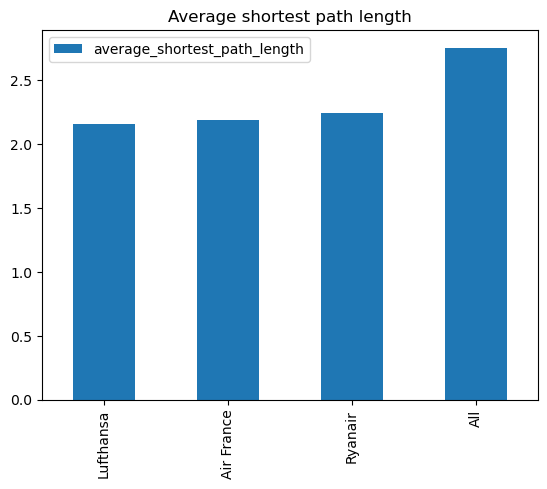

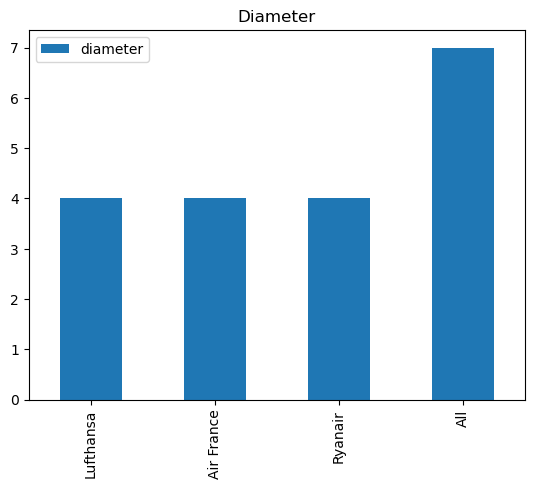

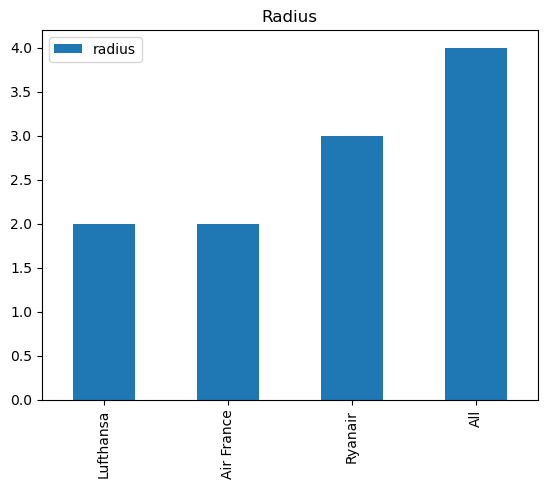

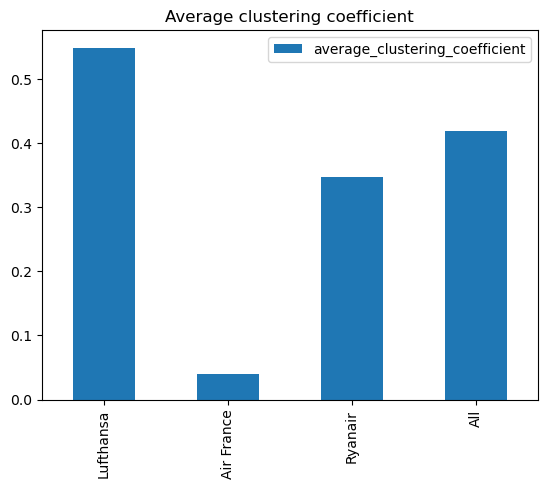

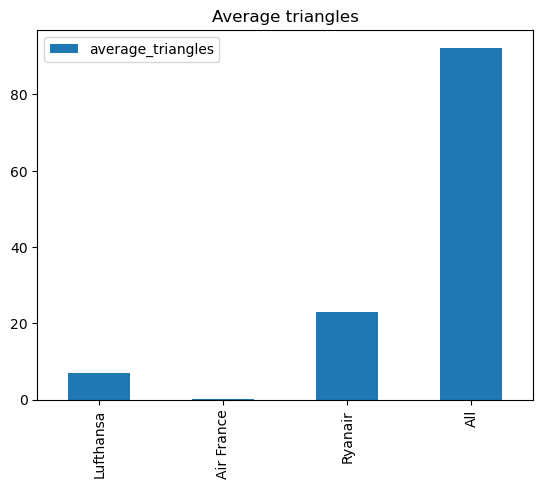

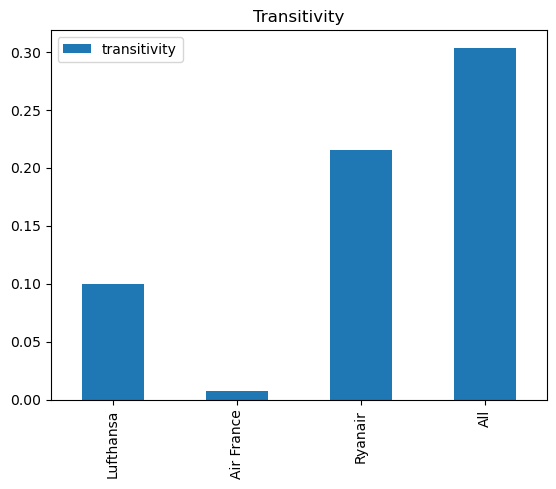

In [31]:
#Plot the results

# Load the results
lufthansa_macroscale_data = load_macroscale_data(
    airline_name="lufthansa",
)

air_france_macroscale_data = load_macroscale_data(
    airline_name="air_france",
)

ryanair_macroscale_data = load_macroscale_data(
    airline_name="ryanair",
)

all_macroscale_data = load_macroscale_data(
    airline_name="all",
)

# Create a DataFrame for each airline
df = pd.DataFrame([
    lufthansa_macroscale_data,
    air_france_macroscale_data,
    ryanair_macroscale_data,
    all_macroscale_data,
], index=["Lufthansa", "Air France", "Ryanair", "All"])
df
df.plot.bar(y='average_shortest_path_length', title='Average shortest path length')
df.plot.bar(y='diameter', title='Diameter')
df.plot.bar(y='radius', title='Radius')
df.plot.bar(y='average_clustering_coefficient', title='Average clustering coefficient')
df.plot.bar(y='average_triangles', title='Average triangles')
df.plot.bar(y='transitivity', title='Transitivity')


The four networks have a very similar shortest path average length of 2 since the majority of destinations are linked by a hub.

The diameters of the three airliners are equal to 4. However, the diameter of the full network is 7, almost the double. This make sense since the global network contains several paths that are not intended to be travelled since they are the union of actual paths from the airlines that conform it.

The radius of the global network is greater than that of the airlines but only 1 edge greater than Ryanair's and 2 than the other ones. This is because the radius of each network is attained at its central nodes. Since the central nodes of these airlines are almost always european capitals to which the other airlines likely have a flight, the central nodes will be connected and hence the radius will be attained at some of them, leading to likely increases of 1 edge.

The transitivity and average number of triangles are related so we will sum them up by analyzing the average number of triangles. As we can see, since Germany is more decentralized than France, its capitals have a large number of triangles, increasing its average value. Ryanair, since it offers a wide range of destinations and is not centered at any particular hub, also yields a network with a large number of triangles. Finally, the average number of triangles in the global network increases drastically. It may be attributed to the fact that if some cities form triangles in an airline, it might mean that they are appealing enough destinations so that there is enough demand to create flights from other cities than the capital. Therefore, these cities might also be appealing enough to attract flights from other appealing cities and vice versa, leading to the formation of more triangles. The clustering coefficient is higher for Lufthansa than for the global network because the later incorporates a lower proportion of triangles to triplets.

In [32]:
# Compute periphery nodes
periphery_lufthansa = nx.periphery(ntw_lufthansa)
node_colors_lufthansa = ["turquoise" if node in periphery_lufthansa else "red" for node in ntw_lufthansa.nodes()]

periphery_air_france = nx.periphery(ntw_air_france)
node_colors_air_france = ["turquoise" if node in periphery_air_france else "red" for node in ntw_air_france.nodes()]

periphery_ryanair = nx.periphery(ntw_ryanair)
node_colors_ryanair = ["turquoise" if node in periphery_ryanair else "red" for node in ntw_ryanair.nodes()]

periphery_all = nx.periphery(ntw_all)
node_colors_all = ["turquoise" if node in periphery_all else "red" for node in ntw_all.nodes()]


In [33]:
# Save interactive periphery maps as images

SAVE_FOLIUM_PERIPHERY = False

if SAVE_FOLIUM_PERIPHERY:

    save_folium_map_as_image(
        m=plot_interactive_map(
            ntw_lufthansa,
            df_airports,
            node_colors=node_colors_lufthansa
        ),
        out_path=OUTPUT_DIR / "ntw_lufthansa_periphery.png",
    )

    i = Image.open(OUTPUT_DIR / "ntw_lufthansa_periphery.png")
    i = i.crop((97, 170, 1436, 938))
    i.save(OUTPUT_DIR / "ntw_lufthansa_periphery.png", "PNG")

    save_folium_map_as_image(
        m=plot_interactive_map(
            ntw_air_france,
            df_airports,
            node_colors=node_colors_air_france
        ),
        out_path=OUTPUT_DIR / "ntw_air_france_periphery.png",
    )
    i = Image.open(OUTPUT_DIR / "ntw_air_france_periphery.png")
    i = i.crop((97, 170, 1436, 938))
    i.save(OUTPUT_DIR / "ntw_air_france_periphery.png", "PNG")

    save_folium_map_as_image(
        m=plot_interactive_map(
            ntw_ryanair,
            df_airports,
            node_colors=node_colors_ryanair
        ),
        out_path=OUTPUT_DIR / "ntw_ryanair_periphery.png",
    )
    i = Image.open(OUTPUT_DIR / "ntw_ryanair_periphery.png")
    i = i.crop((97, 170, 1436, 938))
    i.save(OUTPUT_DIR / "ntw_ryanair_periphery.png", "PNG")

    save_folium_map_as_image(
        m=plot_interactive_map(
            ntw_all,
            df_airports,
            node_colors=node_colors_all
        ),
        out_path=OUTPUT_DIR / "ntw_all_periphery.png",
    )
    i = Image.open(OUTPUT_DIR / "ntw_all_periphery.png")
    i = i.crop((97, 170, 1436, 938))
    i.save(OUTPUT_DIR / "ntw_all_periphery.png", "PNG")


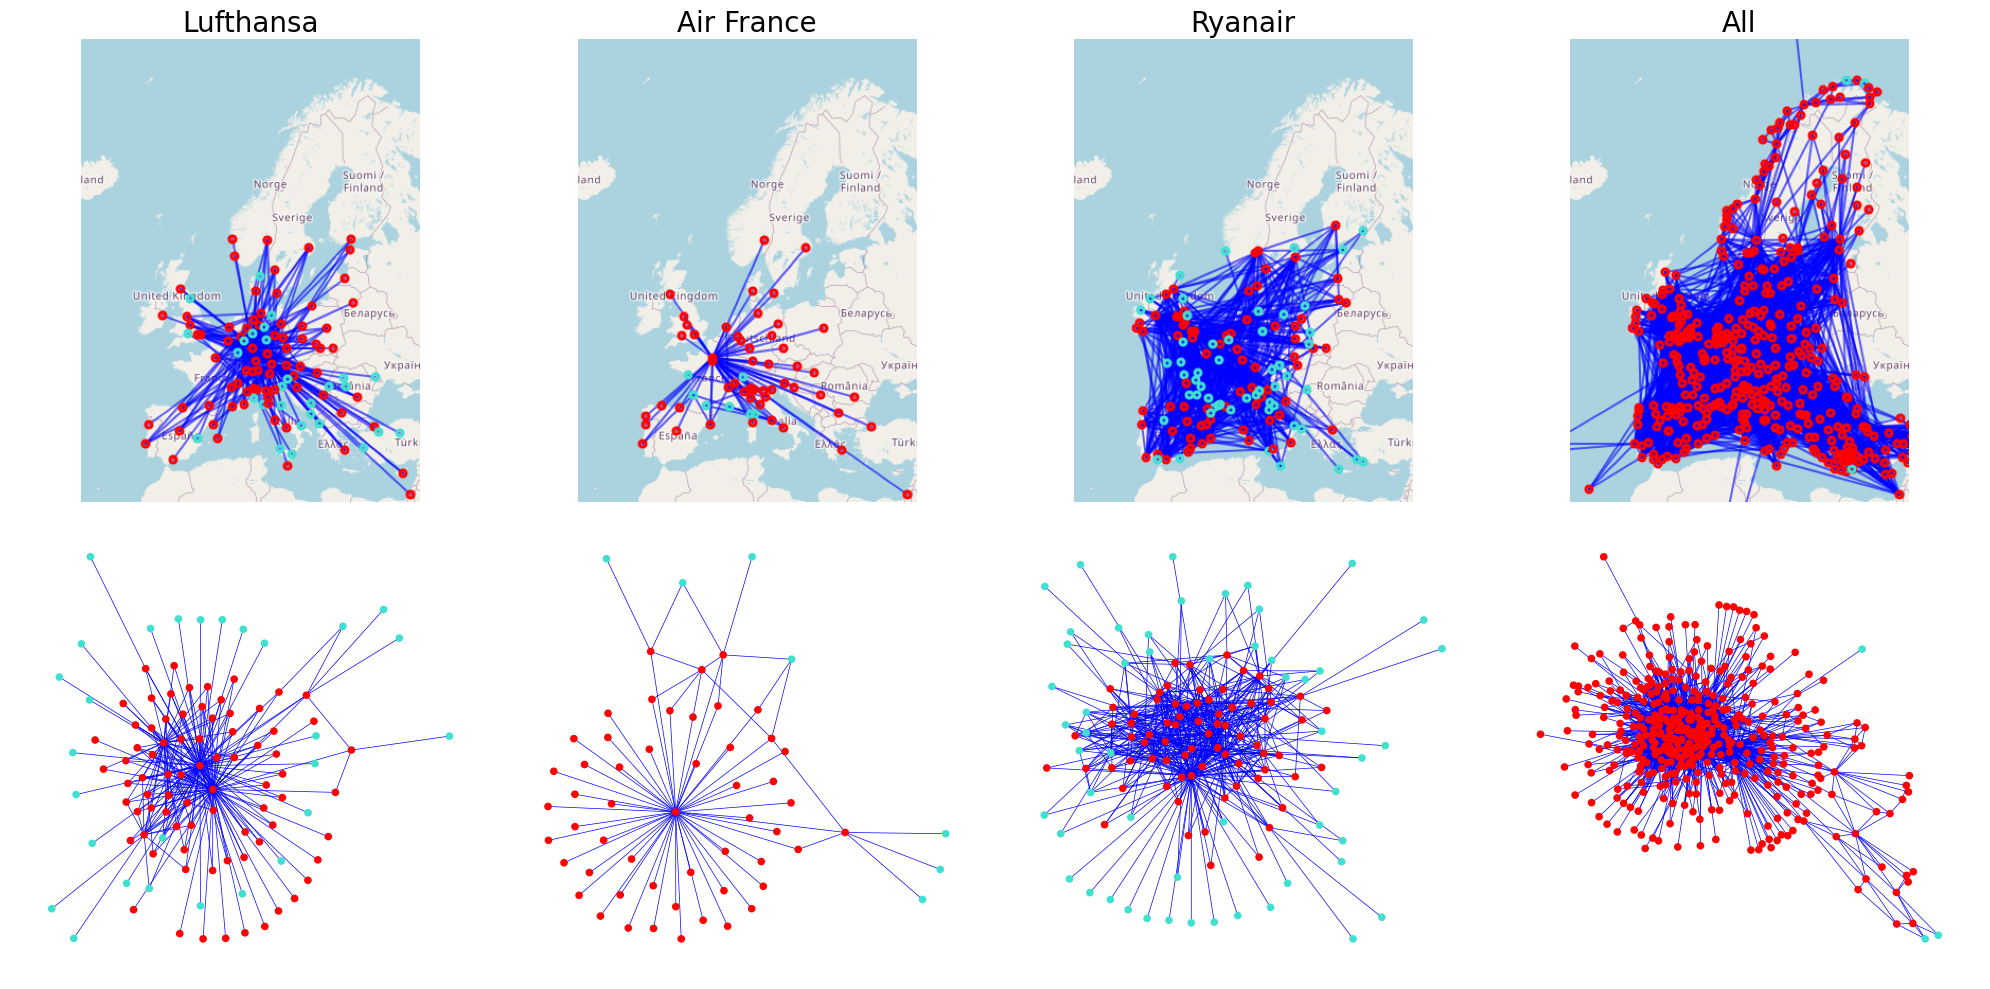

In [34]:
# Plot of the newtorks' periphery
fig, axs = plt.subplots(2, 4, figsize=(20, 10))

for ax in axs.flatten():
    ax.set_axis_off()


plot_static_graph(
    network=ntw_lufthansa,
    png_file_name="ntw_lufthansa_periphery.png",
    column=0,
    network_name="Lufthansa",
    axs=axs,
    node_colors=node_colors_lufthansa
)

plot_static_graph(
    network=ntw_air_france,
    png_file_name="ntw_air_france_periphery.png",
    column=1,
    network_name="Air France",
    axs=axs,
    node_colors=node_colors_air_france
)

plot_static_graph(
    network=ntw_ryanair,
    png_file_name="ntw_ryanair_periphery.png",
    column=2,
    network_name="Ryanair",
    axs=axs,
    node_colors=node_colors_ryanair
)

plot_static_graph(
    network=ntw_all,
    png_file_name="ntw_all_periphery.png",
    column=3,
    network_name="All",
    axs=axs,
    node_colors=node_colors_all
)

plt.tight_layout()
plt.show()


Interestingly, the periphery of the networks is not located in the geographical periphery of the network, but rather inside the country of the airline. This is because it tends to contain smaller cities that don't have enough demand to create international flights or to reserve flights from the capital and so they can only be accessed from undirect flights passing through smaller cities.

In [35]:
def table_freqs_degrees(G):
    """Computes the frequencies of degrees in a graph.

    Args:
        G (nx.Graph) -- NetworkX graph object.

    Returns:
        dict -- Dictionary with degree as key and frequency as value.
    """
    d = dict()
    l = np.array([G.degree(n) for n in G.nodes()])
    for deg in set(l):
        d[deg] = np.sum(l == deg)
    return d

def plot_degree_distribution(G, ax, col):
    """Plots the degree distribution of a graph.

    Args:
        G (nx.Graph) -- NetworkX graph object.
        ax (plt.Axes) -- Matplotlib Axes object to plot on.
        col (int) -- Column index for the plot.
    """
    d = table_freqs_degrees(G)

    ax[0, col].scatter(list(d.keys()), list(d.values()))
    ax[0, col].set_xlabel("Degree")
    ax[0, col].set_ylabel("Frequency")
    ax[0, col].set_title("Degree Distribution, linear scale")

    ax[1, col].scatter(list(d.keys()), list(d.values()))
    ax[1, col].set_yscale('log')
    ax[1, col].set_xscale('log')
    ax[1, col].set_xlabel("Degree")
    ax[1, col].set_ylabel("Frequency")
    ax[1, col].set_title("Degree Distribution, log-log scale")


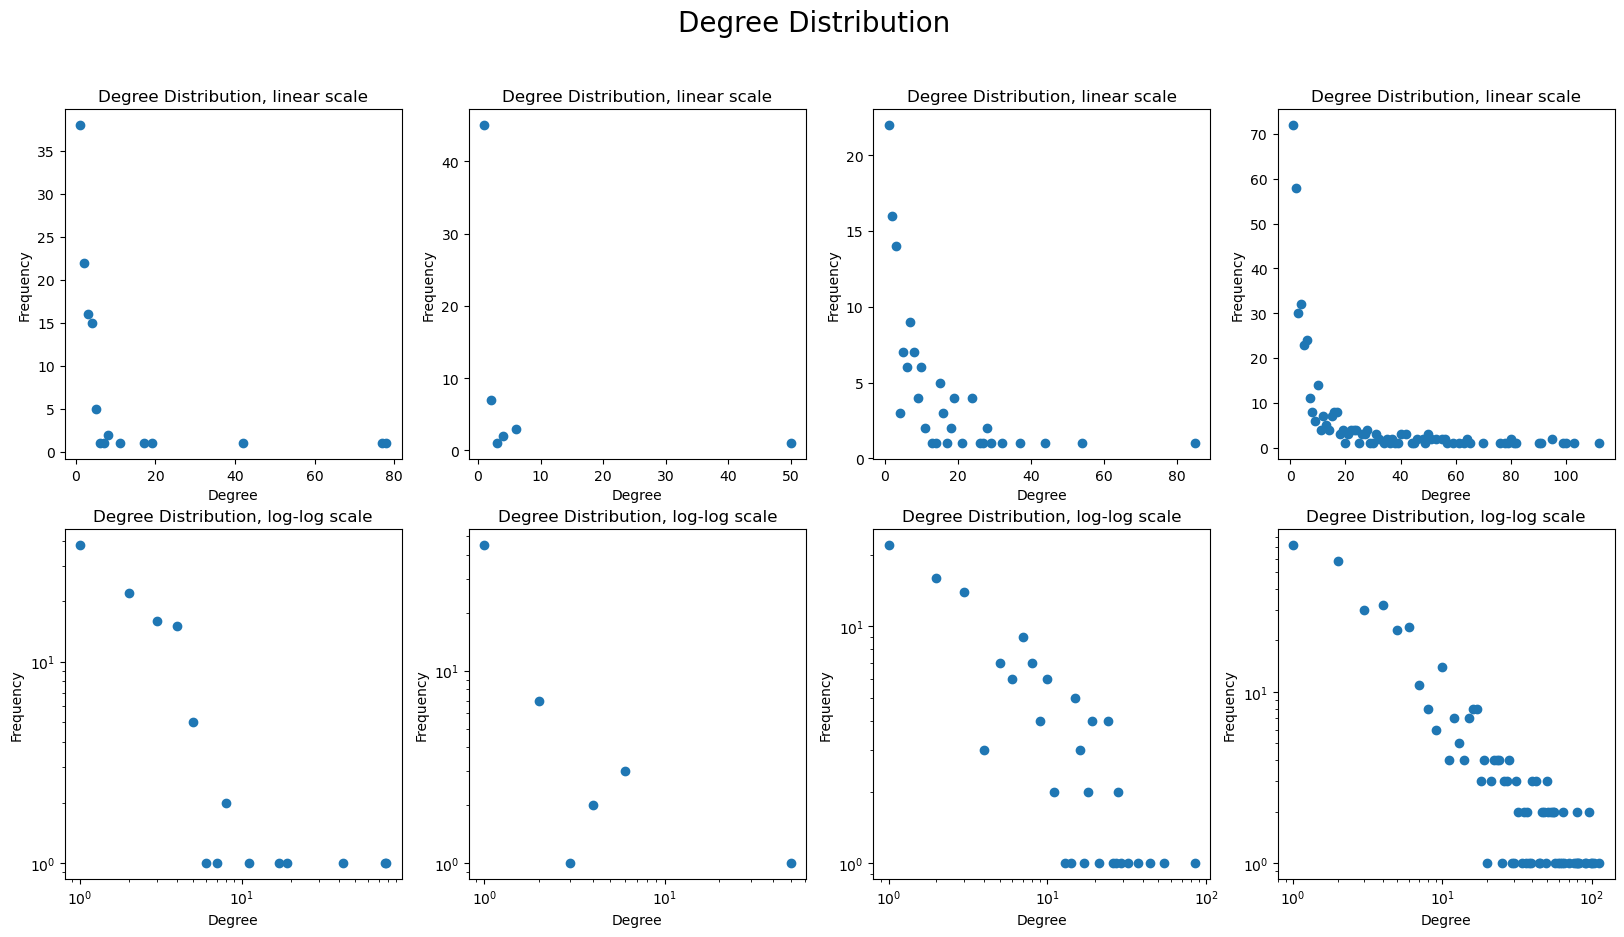

In [36]:
fig, ax = plt.subplots(2, 4, figsize=(20, 10))

fig.suptitle("Degree Distribution", fontsize=20)

plot_degree_distribution(
    G=ntw_lufthansa,
    ax=ax,
    col=0,
)
plot_degree_distribution(
    G=ntw_air_france,
    ax=ax,
    col=1,
)
plot_degree_distribution(
    G=ntw_ryanair,
    ax=ax,
    col=2,
)
plot_degree_distribution(
    G=ntw_all,
    ax=ax,
    col=3,
)


The degree degree distributions follow the same shape as the ones seen in class. It seems likely that they follow a power law, but this should be tested statistically. These degree distributions are interesting mainly for the whole network and for Ryanair's subset, since it is large enough. Lufthansa and Air France have only a few degrees and this makes it difficult to observe any pattern.

***

## **TASK 2**

Before proceeding with the analyses of task 2, we will do a slight modification to our working data. Instead of working with the whole European network as unweighted, we will weigh the edges depending on the number of airlines that serve a connection between two airports.

In [37]:
# Read the file containing the airport connections
def read_multilayer_connections(
    file_path: Path,
) -> list[dict]:
    """Reads the multilayer connections from a file.

    Args:
        file_path (Path) -- Path to the file containing the multilayer connections.

    Returns:
        list -- List containing the multilayer connections.
    """
    layers = []

    with Path.open(file_path, "r") as f_in:
        lines = [line.strip() for line in f_in if line.strip()]

    i = 0
    while i < len(lines):
        num_nodes = int(lines[i])
        i += 1

        edges = []
        for _ in range(num_nodes):
            parts = lines[i].split()
            node_id = int(parts[0])
            neighbors = list(map(int, parts[2:]))
            for neighbor in neighbors:
                edge = tuple(sorted((node_id, neighbor)))  # Undirected
                edges.append(edge)
            i += 1

        layers.append({
            "active_nodes": num_nodes,
            "edges": edges
        })

    return layers


In [38]:
# Read the layers
layers = read_multilayer_connections(DATA_DIR / "network.txt")


In [39]:
# Construct the newtork resulting from collapsing the multilayer network and weigh the edges
# by the number of connections
def collapse_multilayer_network_weighted(layers: list[dict]) -> nx.Graph:
    """Collapses the multilayer network into a single layer and weighs the edges depending on the # of connections.

    Args:
        layers (list) -- List containing the multilayer connections.

    Returns:
        nx.Graph -- Collapsed multilayer network.
    """
    G = nx.Graph()

    for layer in layers:
        for i, j in layer["edges"]:
            if G.has_edge(i, j):
                G[i][j]["weight"] += 1
            else:
                G.add_edge(i, j, weight=1)

    return G

# Collapse the multilayer network
ntw_all_weighted = collapse_multilayer_network_weighted(layers)
graphs.append(ntw_all_weighted)

ntw_all_weighted = select_airline_network(
    airline_name="All_weighted",
    airline_df=df_airlines,
    graphs=graphs,
)




In [ ]:
# Function to plot the graph as an interactive map
def plot_interactive_map_with_weights(
    G: nx.Graph,
    df_airports: pd.DataFrame,
    measure_name: str,
) -> folium.Map:
    """Visualizes the network on a folium map.

    Args:
        G (nx.Graph) -- NetworkX graph object.
        df_airports (pd.DataFrame) -- DataFrame containing airport information.
        microscale_data (dict) -- Microscale data structure.
        measure_name (str) -- Measure to use for coloring nodes.

    Returns:
        folium.Map -- Folium map with the network visualized.
    """
    import branca.colormap as cm
    # Create a folium map centered around the average coordinates
    m = folium.Map(location=[df_airports["latitude"].mean(), df_airports["longitude"].mean()], zoom_start=4)


    # Extract all measure values for normalization
    measure_values = [G[u][v]["weight"] for u, v in G.edges()]
    min_val, max_val = min(measure_values), max(measure_values)

    # Create colormap
    colormap = cm.linear.YlOrRd_04.scale(min_val, max_val)
    colormap.caption = measure_name

    # Add edges to the map
    for edge in G.edges():
        airport1 = df_airports[df_airports["node_id"] == edge[0]].iloc[0]
        airport2 = df_airports[df_airports["node_id"] == edge[1]].iloc[0]
        folium.PolyLine(
            locations=[[airport1["latitude"], airport1["longitude"]],
                       [airport2["latitude"], airport2["longitude"]]],
            color=colormap(G[edge[0]][edge[1]]["weight"]),
            weight=1.4/(max_val - min_val) * G[edge[0]][edge[1]]["weight"] + 0.6,
            opacity=0.2 if G[edge[0]][edge[1]]["weight"] < 2 else 1,
            zorder=100 if G[edge[0]][edge[1]]["weight"] < 2 else 500,
            popup=f"{airport1['name']} <-> {airport2['name']} <br>{measure_name}: {G[edge[0]][edge[1]]['weight']}",
        ).add_to(m)


    # Add nodes to the map
    for node in G.nodes():
        airport = df_airports[df_airports["node_id"] == node].iloc[0]
        folium.CircleMarker(
            location=[airport["latitude"], airport["longitude"]],
            radius=5/(max_val - min_val) * value + 3,
            color="red",
            fill=True,
            fill_color="red",
            fill_opacity=0.25/(max_val - min_val) * value + 0.75,
            popup=f"{airport['name']}",
        ).add_to(m)

    # Add color bar
    colormap.add_to(m)

    return m


In [ ]:
# Load airline names
airline_names = {
    38: "All_weighted"
}

airline_dropdown = widgets.Dropdown(
    options=[(name, idx) for idx, name in airline_names.items()],
    description='Airline:',
    style={'description_width': 'initial'}
)

map_output = widgets.Output()

def update_map(change):
    with map_output:
        clear_output(wait=True)

        # Get selected airline index and measure name
        layer_index = airline_dropdown.value
        measure_name = "Number of connections"

        # Plot the map with the selected values
        m = plot_interactive_map_with_weights(
            graphs[layer_index],
            df_airports,
            measure_name=measure_name,
        )
        display(m)

airline_dropdown.observe(update_map, names='value')
microscale_measure_dropdown.observe(update_map, names='value')

display(widgets.HBox([airline_dropdown]), map_output)

update_map({'new': airline_dropdown.value})


Output()

### **1. Mesoscale Analysis: Communities**

In this part of the task, we will focus on analyzing the mesoscale of our airport networks. In particular, we will explore the following community detection algorithms:
- Greedy modularity maximization.
- Louvain algorithm.
- Girvan-Newman algorithm.

In [42]:
# We will work with the networks:
# - ntw_lufthansa
# - ntw_air_france
# - ntw_ryanair
# - ntw_all_weighted


# --------------------
# 1. Greedy Algorithm
# --------------------
lufthansa_greedy_comms = nx_comm.greedy_modularity_communities(
    ntw_lufthansa,
)
lufthansa_greedy_coms = [list(com) for com in lufthansa_greedy_comms]

air_france_greedy_comms = nx_comm.greedy_modularity_communities(
    ntw_air_france,
)
air_france_greedy_comms = [list(com) for com in air_france_greedy_comms]

ryanair_greedy_comms = nx_comm.greedy_modularity_communities(
    ntw_ryanair,
)
ryanair_greedy_comms = [list(com) for com in ryanair_greedy_comms]

all_weighted_greedy_comms = nx_comm.greedy_modularity_communities(
    ntw_all_weighted,
    weight="weight",
)
all_weighted_greedy_comms = [list(com) for com in all_weighted_greedy_comms]


# ----------------------
# 2. Louvain Algorithm
# ----------------------
lufthansa_louvain_comms = nx_comm.louvain_communities(
    ntw_lufthansa,
)
lufthansa_louvain_comms = [list(com) for com in lufthansa_louvain_comms]

air_france_louvain_comms = nx_comm.louvain_communities(
    ntw_air_france,
)
air_france_louvain_comms = [list(com) for com in air_france_louvain_comms]

ryanair_louvain_comms = nx_comm.louvain_communities(
    ntw_ryanair,
)
ryanair_louvain_comms = [list(com) for com in ryanair_louvain_comms]

all_weighted_louvain_comms = nx_comm.louvain_communities(
    ntw_all_weighted,
    weight="weight",
)
all_weighted_louvain_comms = [list(com) for com in all_weighted_louvain_comms]

# ----------------------
# 3. Girvan-Newman Algorithm (does not work with weighted graphs)
# ----------------------
lufthansa_girvan_newman_comms_1 = nx_comm.girvan_newman(
    ntw_lufthansa,
)
lufthansa_girvan_newman_comms_2 = nx_comm.girvan_newman(
    ntw_lufthansa,
)

air_france_girvan_newman_comms_1 = nx_comm.girvan_newman(
    ntw_air_france,
)
air_france_girvan_newman_comms_2 = nx_comm.girvan_newman(
    ntw_air_france,
)

ryanair_girvan_newman_comms_1 = nx_comm.girvan_newman(
    ntw_ryanair,
)
ryanair_girvan_newman_comms_2 = nx_comm.girvan_newman(
    ntw_ryanair,
)

all_weighted_girvan_newman_comms_1 = nx_comm.girvan_newman(
    ntw_all_weighted,
)
all_weighted_girvan_newman_comms_2 = nx_comm.girvan_newman(
    ntw_all_weighted,
)


In [ ]:
# Function to plot the network with communities in a map
def plot_interactive_map_with_communities(
    G: nx.Graph,
    df_airports: pd.DataFrame,
    communities_dict: dict,
    community_algo_name: str,
) -> folium.Map:
    """Visualizes the network on a folium map.

    Args:
        G (nx.Graph) -- NetworkX graph object.
        df_airports (pd.DataFrame) -- DataFrame containing airport information.
        communities_dict (dict) -- Dictionary containing the communities for different algorithms.
        community_algo_name (str) -- Community algorithm name.

    Returns:
        folium.Map -- Folium map with the network visualized.
    """
    import branca.colormap as cm
    # Create a folium map centered around the average coordinates
    m = folium.Map(location=[df_airports["latitude"].mean(), df_airports["longitude"].mean()], zoom_start=4)


    # Extract all measure values for normalization
    communities = communities_dict[community_algo_name]
    n_communities = len(communities)

    # Create colormap
    colormap = cm.linear.Set2_08.to_step(n_communities).scale(0, n_communities)
    # colormap.caption = measure_name

    # Add edges to the map
    for edge in G.edges():
        airport1 = df_airports[df_airports["node_id"] == edge[0]].iloc[0]
        airport2 = df_airports[df_airports["node_id"] == edge[1]].iloc[0]
        folium.PolyLine(
            locations=[[airport1["latitude"], airport1["longitude"]],
                       [airport2["latitude"], airport2["longitude"]]],
            color="blue",
            weight=0.4,
            opacity=0.2,
            popup=f"{airport1['name']} <-> {airport2['name']}",
        ).add_to(m)


    # Add nodes to the map
    for node in G.nodes():
        airport = df_airports[df_airports["node_id"] == node].iloc[0]
        node_community_idxs = [communities.index(community) for community in communities if node in community]
        try:
            assert len(node_community_idxs) == 1
        except AssertionError:
            print(f"Node {node} is in multiple communities: {node_community_idxs}")
            raise

        node_community_idx = node_community_idxs[0]
        folium.CircleMarker(
            location=[airport["latitude"], airport["longitude"]],
            radius=8,
            color=colormap(node_community_idx),
            fill=True,
            fill_color=colormap(node_community_idx),
            fill_opacity=1.0,
            popup=f"{airport['name']}",
        ).add_to(m)

    # Add color bar
    colormap.add_to(m)

    return m


In [44]:
import itertools

max_k = 25

lufthansa_communities_dict = {
    "Greedy": list(lufthansa_greedy_comms),
    "Louvain": list(lufthansa_louvain_comms),
    "Girvan-Newman": lufthansa_girvan_newman_comms_1,
}

for idx, k in enumerate(itertools.takewhile(lambda k: len(k) <= max_k, lufthansa_girvan_newman_comms_2)):
    lufthansa_communities_dict[f"Girvan-Newman {idx}"] = [list(community) for community in k]

air_france_communities_dict = {
    "Greedy": list(air_france_greedy_comms),
    "Louvain": list(air_france_louvain_comms),
    "Girvan-Newman": air_france_girvan_newman_comms_1,
}
for idx, k in enumerate(itertools.takewhile(lambda k: len(k) <= max_k, air_france_girvan_newman_comms_2)):
    air_france_communities_dict[f"Girvan-Newman {idx}"] = [list(community) for community in k]


ryanair_communities_dict = {
    "Greedy": list(ryanair_greedy_comms),
    "Louvain": list(ryanair_louvain_comms),
    "Girvan-Newman": ryanair_girvan_newman_comms_1,
}
for idx, k in enumerate(itertools.takewhile(lambda k: len(k) <= max_k, ryanair_girvan_newman_comms_2)):
    ryanair_communities_dict[f"Girvan-Newman {idx}"] = [list(community) for community in k]

all_weighted_communities_dict = {
    "Greedy": list(all_weighted_greedy_comms),
    "Louvain": list(all_weighted_louvain_comms),
    "Girvan-Newman": all_weighted_girvan_newman_comms_2
}
for idx, k in enumerate(itertools.takewhile(lambda k: len(k) <= max_k, all_weighted_girvan_newman_comms_2)):
    all_weighted_communities_dict[f"Girvan-Newman {idx}"] = [list(community) for community in k]


In [45]:
# Load airline names
airline_names = {
    0: "Lufthansa",
    1: "Ryanair",
    6: "Air France",
    38: "All_weighted"
}

communities_dicts = {
    0: lufthansa_communities_dict,
    1: ryanair_communities_dict,
    6: air_france_communities_dict,
    38: all_weighted_communities_dict,
}

# Step 2: Create dropdown with airline names
airline_dropdown = widgets.Dropdown(
    options=[(name, idx) for idx, name in airline_names.items()],
    description='Airline:',
    style={'description_width': 'initial'}
)

algorithm_dropdown = widgets.Dropdown(
    options=[k for k in lufthansa_communities_dict.keys() if k != "Girvan-Newman"],
    description='Algorithm:',
    style={'description_width': 'initial'}
)

# Output widget to hold the map
map_output = widgets.Output()

# Step 3: Define update function
def update_map(change):
    with map_output:
        clear_output(wait=True)

        # Get selected airline index and measure name
        layer_index = airline_dropdown.value
        algorithm_name = algorithm_dropdown.value

        # Plot the map with the selected values
        m = plot_interactive_map_with_communities(
            graphs[layer_index],
            df_airports,
            communities_dict=communities_dicts[layer_index],
            community_algo_name=algorithm_name,
        )
        display(m)

# Step 4: Connect dropdowns to update function
airline_dropdown.observe(update_map, names='value')
algorithm_dropdown.observe(update_map, names='value')

# Display the widgets
display(widgets.HBox([airline_dropdown, algorithm_dropdown]), map_output)

# Step 5: Trigger initial map update manually
update_map({'new': airline_dropdown.value})


Output()

In [ ]:
import networkx as nx
from itertools import chain, combinations
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram

# Source of this function: https://stackoverflow.com/questions/59821151/plot-the-dendrogram-of-communities-found-by-networkx-girvan-newman-algorithm
def plot_girvan_newman_dendrogram(gn_communities, title="Girvan-Newman Dendrogram", save_path=None, df_airports=df_airports):
    """
    Plots a dendrogram for the Girvan-Newman communities.

    Parameters:
    - gn_communities: generator or list of tuples of sets (output of nx.community.girvan_newman)
    - title: plot title
    - save_path: if specified, saves the plot to this file

    Returns:
    - None
    """

    # Convert generator to list if needed
    gn_communities = list(gn_communities)

    # Build initial dict mapping node_id to community set (avoid duplicates)
    node_id = 0
    init_node2community_dict = {node_id: gn_communities[0][0].union(gn_communities[0][1])}
    for comm in gn_communities:
        for subset in comm:
            if subset not in init_node2community_dict.values():
                node_id += 1
                init_node2community_dict[node_id] = subset

    # Build a dict mapping node_id to their children node_ids
    node_id_to_children = {e: [] for e in init_node2community_dict.keys()}
    for node_id1, node_id2 in combinations(init_node2community_dict.keys(), 2):
        for node_id_parent, group in init_node2community_dict.items():
            # If node_id1 and node_id2 are disjoint subsets whose union equals group
            if (init_node2community_dict[node_id1].isdisjoint(init_node2community_dict[node_id2]) and
                group == init_node2community_dict[node_id1].union(init_node2community_dict[node_id2])):
                node_id_to_children[node_id_parent].append(node_id1)
                node_id_to_children[node_id_parent].append(node_id2)

    # Map node_ids to labels (for leaves, show node; for inner nodes, empty string)
    node_labels = {}
    for node_id, group in init_node2community_dict.items():
        if len(group) == 1:
            node_labels[node_id] = list(group)[0]
        else:
            node_labels[node_id] = ''

    # Build a rank dict for ordering merges uniquely (needed for dendrogram height)
    subset_rank_dict = {}
    rank = 0
    for e in reversed(gn_communities):
        for p in e:
            key = tuple(sorted(p))
            if key not in subset_rank_dict:
                subset_rank_dict[key] = rank
                rank += 1
    # Also add the union of all nodes (root)
    full_set = tuple(sorted(chain.from_iterable(gn_communities[-1])))
    subset_rank_dict[full_set] = rank

    def get_merge_height(sub):
        sub_tuple = tuple(sorted([node_labels[i] for i in sub]))
        n = len(sub_tuple)
        same_len_merges = {k: v for k, v in subset_rank_dict.items() if len(k) == n}
        min_rank = min(same_len_merges.values())
        max_rank = max(same_len_merges.values())
        denom = (max_rank - min_rank) if max_rank > min_rank else 1
        # Height = cluster size + scaled rank in range [0,1]
        return float(len(sub)) + 0.8 * (subset_rank_dict[sub_tuple] - min_rank) / denom

    # Build graph of merges and find leaves and inner nodes
    G_merge = nx.DiGraph(node_id_to_children)
    nodes = list(G_merge.nodes())
    leaves = {n for n in nodes if G_merge.out_degree(n) == 0}
    inner_nodes = [n for n in nodes if G_merge.out_degree(n) > 0]

    # Compute subtree leaves for each node
    subtree = {n: [n] for n in leaves}
    for u in inner_nodes:
        children = set()
        node_list = list(node_id_to_children[u])
        while node_list:
            v = node_list.pop(0)
            children.add(v)
            node_list.extend(node_id_to_children[v])
        subtree[u] = sorted(children & leaves)

    inner_nodes.sort(key=lambda n: len(subtree[n]))  # sort by size

    # Build linkage matrix Z for dendrogram
    leaves = sorted(leaves)
    index = { (n,): i for i, n in enumerate(leaves) }
    Z = []
    k = len(leaves)
    for n in inner_nodes:
        children = node_id_to_children[n]
        x = children[0]
        for y in children[1:]:
            z = tuple(sorted(subtree[x] + subtree[y]))
            i, j = index[tuple(sorted(subtree[x]))], index[tuple(sorted(subtree[y]))]
            Z.append([i, j, get_merge_height(subtree[n]), len(z)])
            index[z] = k
            subtree[z] = list(z)
            x = z
            k += 1

    # Plot dendrogram
    plt.figure(figsize=(12, 8))
    dendrogram(Z, labels=[node_labels[n] for n in leaves], orientation='top')
    plt.title(title)
    plt.xlabel("Nodes")
    # Set x-tick labels to airport names
    ax = plt.gca()
    labels = [df_airports[df_airports["node_id"] == n]["name"].values[0] if not df_airports[df_airports["node_id"] == n]["name"].empty else n for n in leaves]
    ax.set_xticklabels(labels, rotation=90)
    plt.ylabel("Cluster size / Merge step")
    if save_path:
        plt.savefig(save_path)
    plt.show()


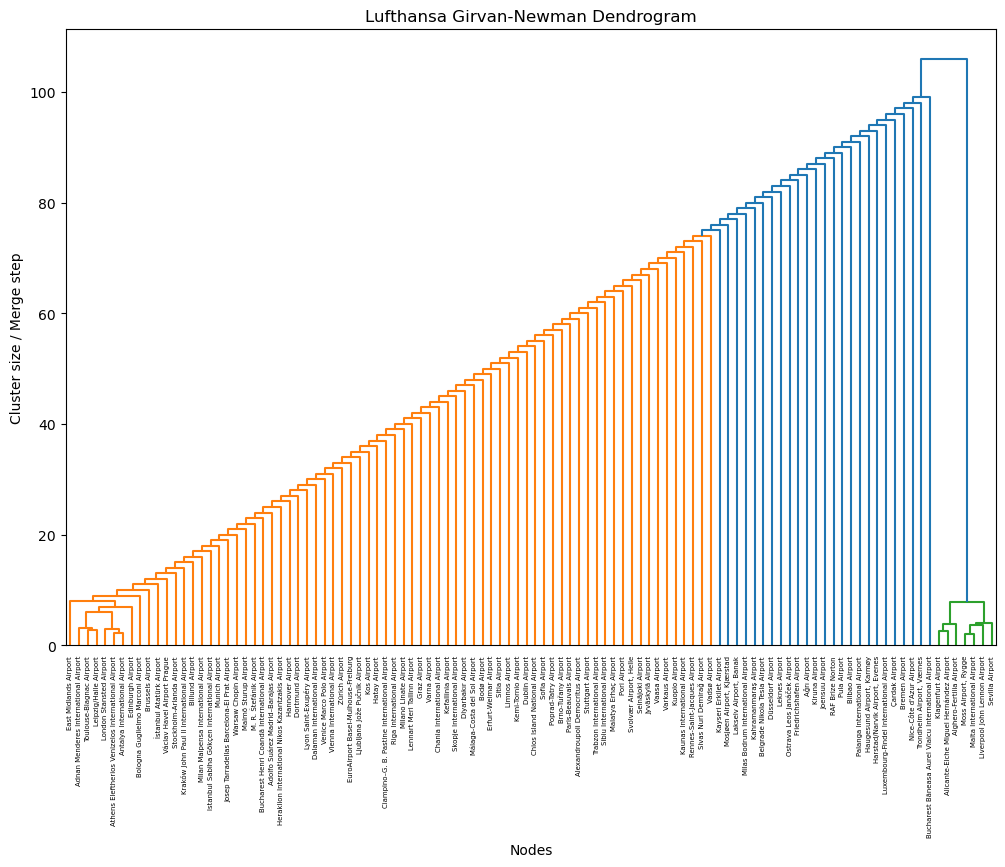

In [47]:
# Plot the Girvan-Newman dendrogram for Lufthansa
plot_girvan_newman_dendrogram(
    gn_communities=lufthansa_communities_dict["Girvan-Newman"],
    title="Lufthansa Girvan-Newman Dendrogram",
)


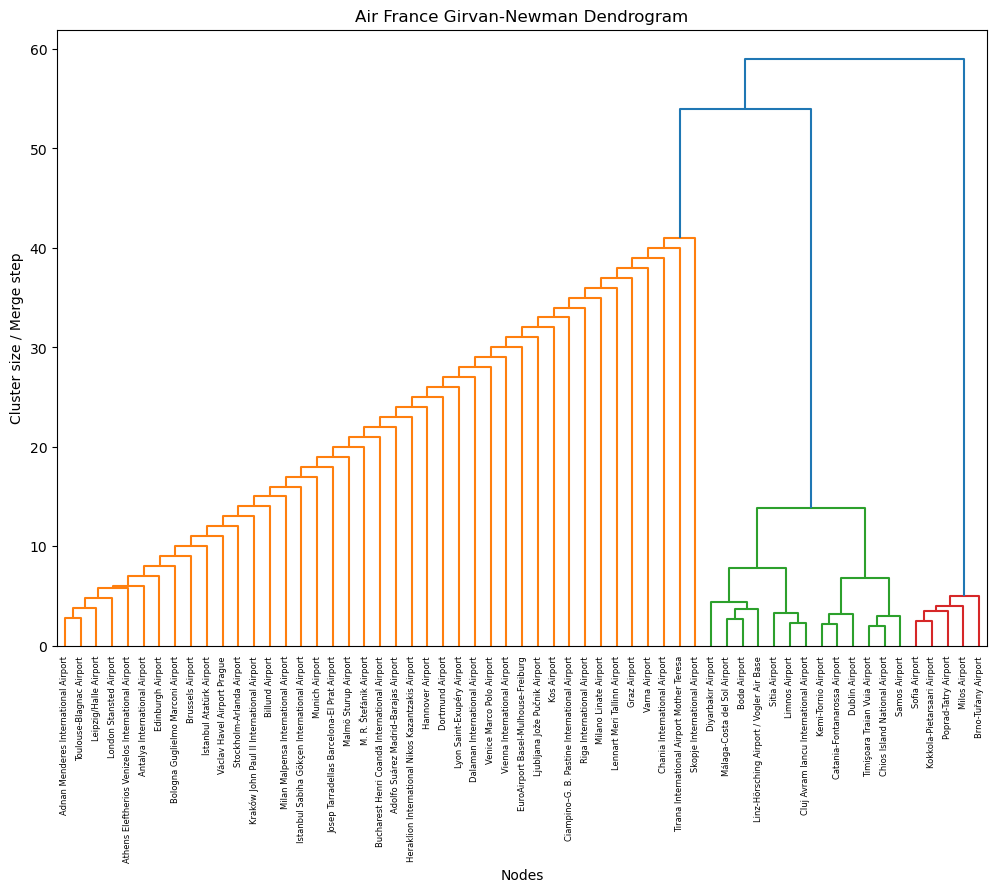

In [48]:
# Plot the Girvan-Newman dendrogram for Air France
plot_girvan_newman_dendrogram(
    gn_communities=air_france_communities_dict["Girvan-Newman"],
    title="Air France Girvan-Newman Dendrogram",
)


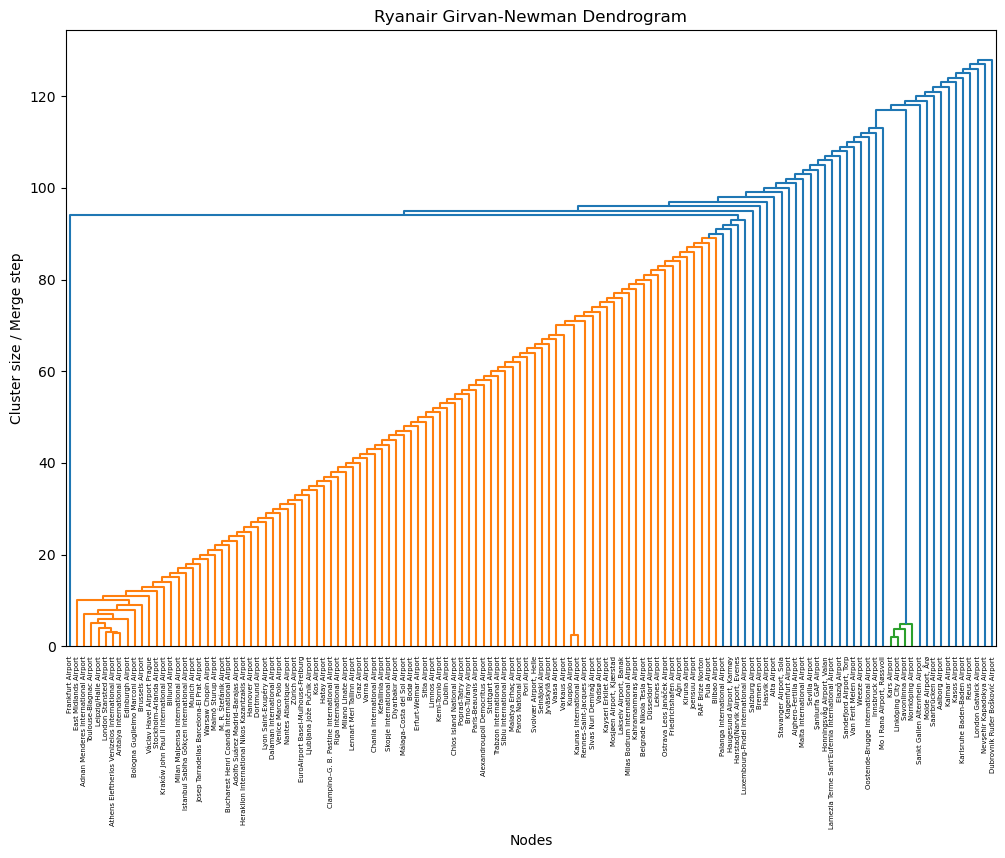

In [49]:
# Plot the Girvan-Newman dendrogram for Ryanair
plot_girvan_newman_dendrogram(
    gn_communities=ryanair_communities_dict["Girvan-Newman"],
    title="Ryanair Girvan-Newman Dendrogram",
)


[TODO] Comentar resultats de communities.

### **2. Dynamic Analysis**

#### **2.1. Random Walks**

Let us simulate random walks in our networks and see the final distribution of walkers around them.

In [50]:
# Function to simulate a random walk around a network
def random_walk(G, start_node, num_steps):
    """Performs a random walk on the graph G.

    Args:
        G (nx.Graph) -- NetworkX graph object.
        start_node (int) -- Starting node for the random walk.
        num_steps (int) -- Number of steps to take in the random walk.

    Returns:
        list -- List of nodes visited during the random walk.
    """
    current_node = start_node
    path = [current_node]

    for _ in range(num_steps):
        neighbors = list(G.neighbors(current_node))
        if not neighbors:
            break
        current_node = np.random.choice(neighbors)
        path.append(current_node)

    return path

# Function to uniformly distribute n_walkers random walkers and simulate their paths
def simulate_random_walks(G, n_walkers, num_steps):
    """Simulates random walks on the graph G.

    Args:
        G (nx.Graph) -- NetworkX graph object.
        n_walkers (int) -- Number of random walkers.
        num_steps (int) -- Number of steps to take in each random walk.

    Returns:
        list -- List of paths taken by each walker.
    """
    paths = []
    from tqdm.auto import tqdm
    for _ in tqdm(range(n_walkers)):
        start_node = np.random.choice(G.nodes())
        path = random_walk(G, start_node, num_steps)
        paths.append(path)
    return paths

N_WALKERS = 1000
N_STEPS = 10000

# Simulate the random walks for each airline network
print("Simulating random walks for Lufthansa...")
walks_lufthansa = simulate_random_walks(
    ntw_lufthansa,
    n_walkers=N_WALKERS,
    num_steps=N_STEPS,
)

print("Simulating random walks for Air France...")
walks_air_france = simulate_random_walks(
    ntw_air_france,
    n_walkers=N_WALKERS,
    num_steps=N_STEPS,
)

print("Simulating random walks for Ryanair...")
walks_ryanair = simulate_random_walks(
    ntw_ryanair,
    n_walkers=N_WALKERS,
    num_steps=N_STEPS,
)

print("Simulating random walks for All...")
walks_all = simulate_random_walks(
    ntw_all_weighted,
    n_walkers=N_WALKERS,
    num_steps=N_STEPS,
)


Simulating random walks for Lufthansa...


  0%|          | 0/1000 [00:00<?, ?it/s]

Simulating random walks for Air France...


  0%|          | 0/1000 [00:00<?, ?it/s]

Simulating random walks for Ryanair...


  0%|          | 0/1000 [00:00<?, ?it/s]

Simulating random walks for All...


  0%|          | 0/1000 [00:00<?, ?it/s]

In [54]:
import ipywidgets as widgets
from IPython.display import display, clear_output

# Prepare data for dropdowns
airline_options = [
    ("Lufthansa", 0),
    ("Air France", 6),
    ("Ryanair", 1),
    ("All_weighted", 38)
]
walks_dict = {
    0: walks_lufthansa,
    6: walks_air_france,
    1: walks_ryanair,
    38: walks_all
}

measure_options = [
    ("Number of walkers at the end", "end"),
    ("Number of transits", "transit")
]

# Dropdown widgets
airline_dropdown = widgets.Dropdown(
    options=airline_options,
    value=6,
    description="Airline:"
)
measure_dropdown = widgets.Dropdown(
    options=measure_options,
    value="transit",
    description="Measure:"
)

map_output = widgets.Output()

def plot_random_walks_map_selectable(
    G: nx.Graph,
    df_airports: pd.DataFrame,
    walks: list[list[int]],
    measure: str,
    title: str
) -> folium.Map:
    m = folium.Map(location=[df_airports["latitude"].mean(), df_airports["longitude"].mean()], zoom_start=4)

    if measure == "transit":
        node_counts = {node: 0 for node in G.nodes()}
        for path in walks:
            for node in path:
                node_counts[node] += 1
        popup_label = "transits"
    else:  # "end"
        node_counts = {node: 0 for node in G.nodes()}
        for path in walks:
            node_counts[path[-1]] += 1
        popup_label = "walkers ended"

    for edge in G.edges():
        airport1 = df_airports[df_airports["node_id"] == edge[0]].iloc[0]
        airport2 = df_airports[df_airports["node_id"] == edge[1]].iloc[0]
        folium.PolyLine(
            locations=[[airport1["latitude"], airport1["longitude"]],
                       [airport2["latitude"], airport2["longitude"]]],
            color="blue",
            weight=0.4,
            opacity=0.2,
        ).add_to(m)

    max_count = max(node_counts.values()) if node_counts else 1
    for node, count in node_counts.items():
        airport = df_airports[df_airports["node_id"] == node].iloc[0]
        import branca.colormap as cm

        # Create a colormap from min to max count
        colormap = cm.linear.RdYlBu_04.scale(0, max_count).to_step(n=256)
        # Reverse the colormap by creating a new colormap with reversed colors
        colormap.colors = colormap.colors[::-1]
        colormap.caption = f"Number of {popup_label}"

        folium.CircleMarker(
            location=[airport["latitude"], airport["longitude"]],
            radius=5 * count / max_count + 4,
            color=colormap(count),
            fill=True,
            fill_color=colormap(count),
            fill_opacity=0.5 * count / max_count + 0.75,
            popup=f"{airport['name']}: {count} {popup_label}",
        ).add_to(m)

        # Add colormap to map (only once)
        if node == list(node_counts.keys())[0]:
            colormap.add_to(m)
    return m

def update_map(change=None):
    with map_output:
        clear_output(wait=True)
        idx = airline_dropdown.value
        measure = measure_dropdown.value
        m = plot_random_walks_map_selectable(
            G=graphs[idx],
            df_airports=df_airports,
            walks=walks_dict[idx],
            measure=measure,
            title=f"{airline_dropdown.label} - Random Walks"
        )
        display(m)

airline_dropdown.observe(update_map, names='value')
measure_dropdown.observe(update_map, names='value')

display(widgets.HBox([airline_dropdown, measure_dropdown]), map_output)
update_map()


Output()

In [52]:
airline_microscale_data[38] = airline_microscale_data[37]


In [55]:
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, clear_output

%matplotlib widget
# Widgets
airline_dropdown = widgets.Dropdown(
    options=[(name, idx) for idx, name in airline_names.items()],
    description='Airline:',
    style={'description_width': 'initial'}
)

microscale_measure_dropdown = widgets.Dropdown(
    options=[
        "degree_centrality",
        "closeness_centrality",
        "betweenness_centrality",
        "eigenvector_centrality",
        "pagerank_centrality",
        "katz_centrality",
        "clustering_coefficient"
    ],
    description='X-axis (Microscale Measure):',
    style={'description_width': 'initial'}
)

walker_measure_dropdown = widgets.Dropdown(
    options=[
        ("Number of walkers at the end", "end"),
        ("Number of transits", "transit")
    ],
    description='Y-axis (Walker Count):',
    style={'description_width': 'initial'}
)

xscale_dropdown = widgets.Dropdown(
    options=["linear", "log"],
    value="linear",
    description="X Scale:",
    style={'description_width': 'initial'}
)

yscale_dropdown = widgets.Dropdown(
    options=["linear", "log"],
    value="linear",
    description="Y Scale:",
    style={'description_width': 'initial'}
)

# Function to compute walker-based node counts
def compute_node_counts(G, walks, measure):
    node_counts = {node: 0 for node in G.nodes()}
    if measure == "transit":
        for path in walks:
            for node in path:
                node_counts[node] += 1
    elif measure == "end":
        for path in walks:
            if path:
                node_counts[path[-1]] += 1
    return node_counts

# Scatter plot function for microscale dicts
def plot_scatter_xy(G, microscale_dict, walks, x_measure, y_measure, title="", xscale="linear", yscale="linear"):
    y_counts = compute_node_counts(G, walks, y_measure)

    x = []
    y = []
    for node in G.nodes():
        if node in microscale_dict and x_measure in microscale_dict[node]:
            x_val = microscale_dict[node][x_measure]
            y_val = y_counts[node]
            x.append(x_val)
            y.append(y_val)

    label_dict = {val: label for label, val in walker_measure_dropdown.options}

    plt.figure(figsize=(8, 6))
    plt.scatter(x, y, alpha=0.6)
    plt.xlabel(x_measure.replace("_", " ").title())
    plt.ylabel(label_dict[y_measure])
    plt.xscale(xscale)
    plt.yscale(yscale)
    plt.title(title)
    plt.grid(True)
    plt.show()


# Output widget
scatter_output = widgets.Output()

# Update callback
def update_scatter(change):
    with scatter_output:
        clear_output(wait=True)

        airline_idx = airline_dropdown.value
        x_measure = microscale_measure_dropdown.value
        y_measure = walker_measure_dropdown.value
        xscale = xscale_dropdown.value
        yscale = yscale_dropdown.value

        G = graphs[airline_idx]
        microscale_dict = airline_microscale_data[airline_idx]
        walks = walks_dict[airline_idx]

        title = f"{airline_names[airline_idx]}: {x_measure} vs {[label for label, val in walker_measure_dropdown.options if val == y_measure][0]}"
        plot_scatter_xy(G, microscale_dict, walks, x_measure, y_measure, title, xscale, yscale)

# Observe changes
for w in [airline_dropdown, microscale_measure_dropdown, walker_measure_dropdown, xscale_dropdown, yscale_dropdown]:
    w.observe(update_scatter, names='value')

# Display interface

controls = widgets.HBox([airline_dropdown, microscale_measure_dropdown, walker_measure_dropdown])
scales = widgets.HBox([xscale_dropdown, yscale_dropdown])
display(controls, scales, scatter_output)

update_scatter({'new': airline_dropdown.value})


Output()

[TODO] Comentar resultats de random walks